In [1]:
import src
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import matplotlib as mpl
mpl.use('TkAgg')
from matplotlib import cm
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import MaxNLocator
from pathlib import Path

%matplotlib inline
plt.rcParams.update({
    # "text.usetex": True,
    # "font.family": "serif",
    # "font.serif": ["Computer Modern Roman"],
    "font.size": 12,
})

%load_ext autoreload
%autoreload 2

In [2]:
HOME_DIR, BASE_DIR, CODE_DIR, TB_DIR, RMS_DATA_DIR = src.config.config_paths()

In [3]:
expLabels = [
    'Test 11',
    'Test 14',
    'Test 15',
    'Test 16',
    'Test 17',
    'Test 18',
    'Test 19',
    'Test 21',
]

exps = [src.load(label) for label in expLabels]

# exps[0].features.drop([0, 23, 24], inplace=True)
# exps[0].features.drop([23, 24], inplace=True)

for exp in exps:
    exp.features.loc[:,['Form error', 'Runout']] = exp.features.loc[:, ['Form error', 'Runout']]*1000

In [4]:
data_names = ['mean_radius', 'peak_radius', 'runout', 'form_error']

m_rad = [exp.nc4.mean_radius for exp in exps]
p_rad = [exp.nc4.peak_radius for exp in exps]
runout = [exp.nc4.runout for exp in exps]
form_error = [exp.nc4.form_error for exp in exps]

data = [m_rad, p_rad, runout, form_error]

In [5]:
info = []
for i, exp in enumerate(exps):
    info.append([i + 1, len(exp.features) - 1, exp.features['Runout'].iloc[0], exp.features['Runout'].mean(), exp.features['Form error'].iloc[0], exp.features['Form error'].mean()])

df = pd.DataFrame(info, columns=['Test No', 'No Cuts', 'Initial Runout', 'Average Runout', 'Initial Form Error', 'Average Form Error'])
df.set_index('Test No', inplace=True)
df

No Cuts  Initial Runout  Average Runout  Initial Form Error  \
Test No                                                                
1            139       11.797651        7.648310           14.602152   
2            125        1.161086       11.892437            7.810802   
3            141        5.845110        8.031790           11.864984   
4            141        3.608304       11.749196            8.473299   
5            139        2.714843        4.327876            7.793315   
6            135       11.523844        8.366531           18.419047   
7            140        5.013417        7.985792           11.034049   
8            107       36.493301       25.157317           38.440018   

         Average Form Error  
Test No                      
1                 12.600495  
2                 15.217174  
3                 12.249981  
4                 14.911025  
5                  9.234670  
6                 12.382269  
7                 11.835689  
8                 26.748871

## NC4

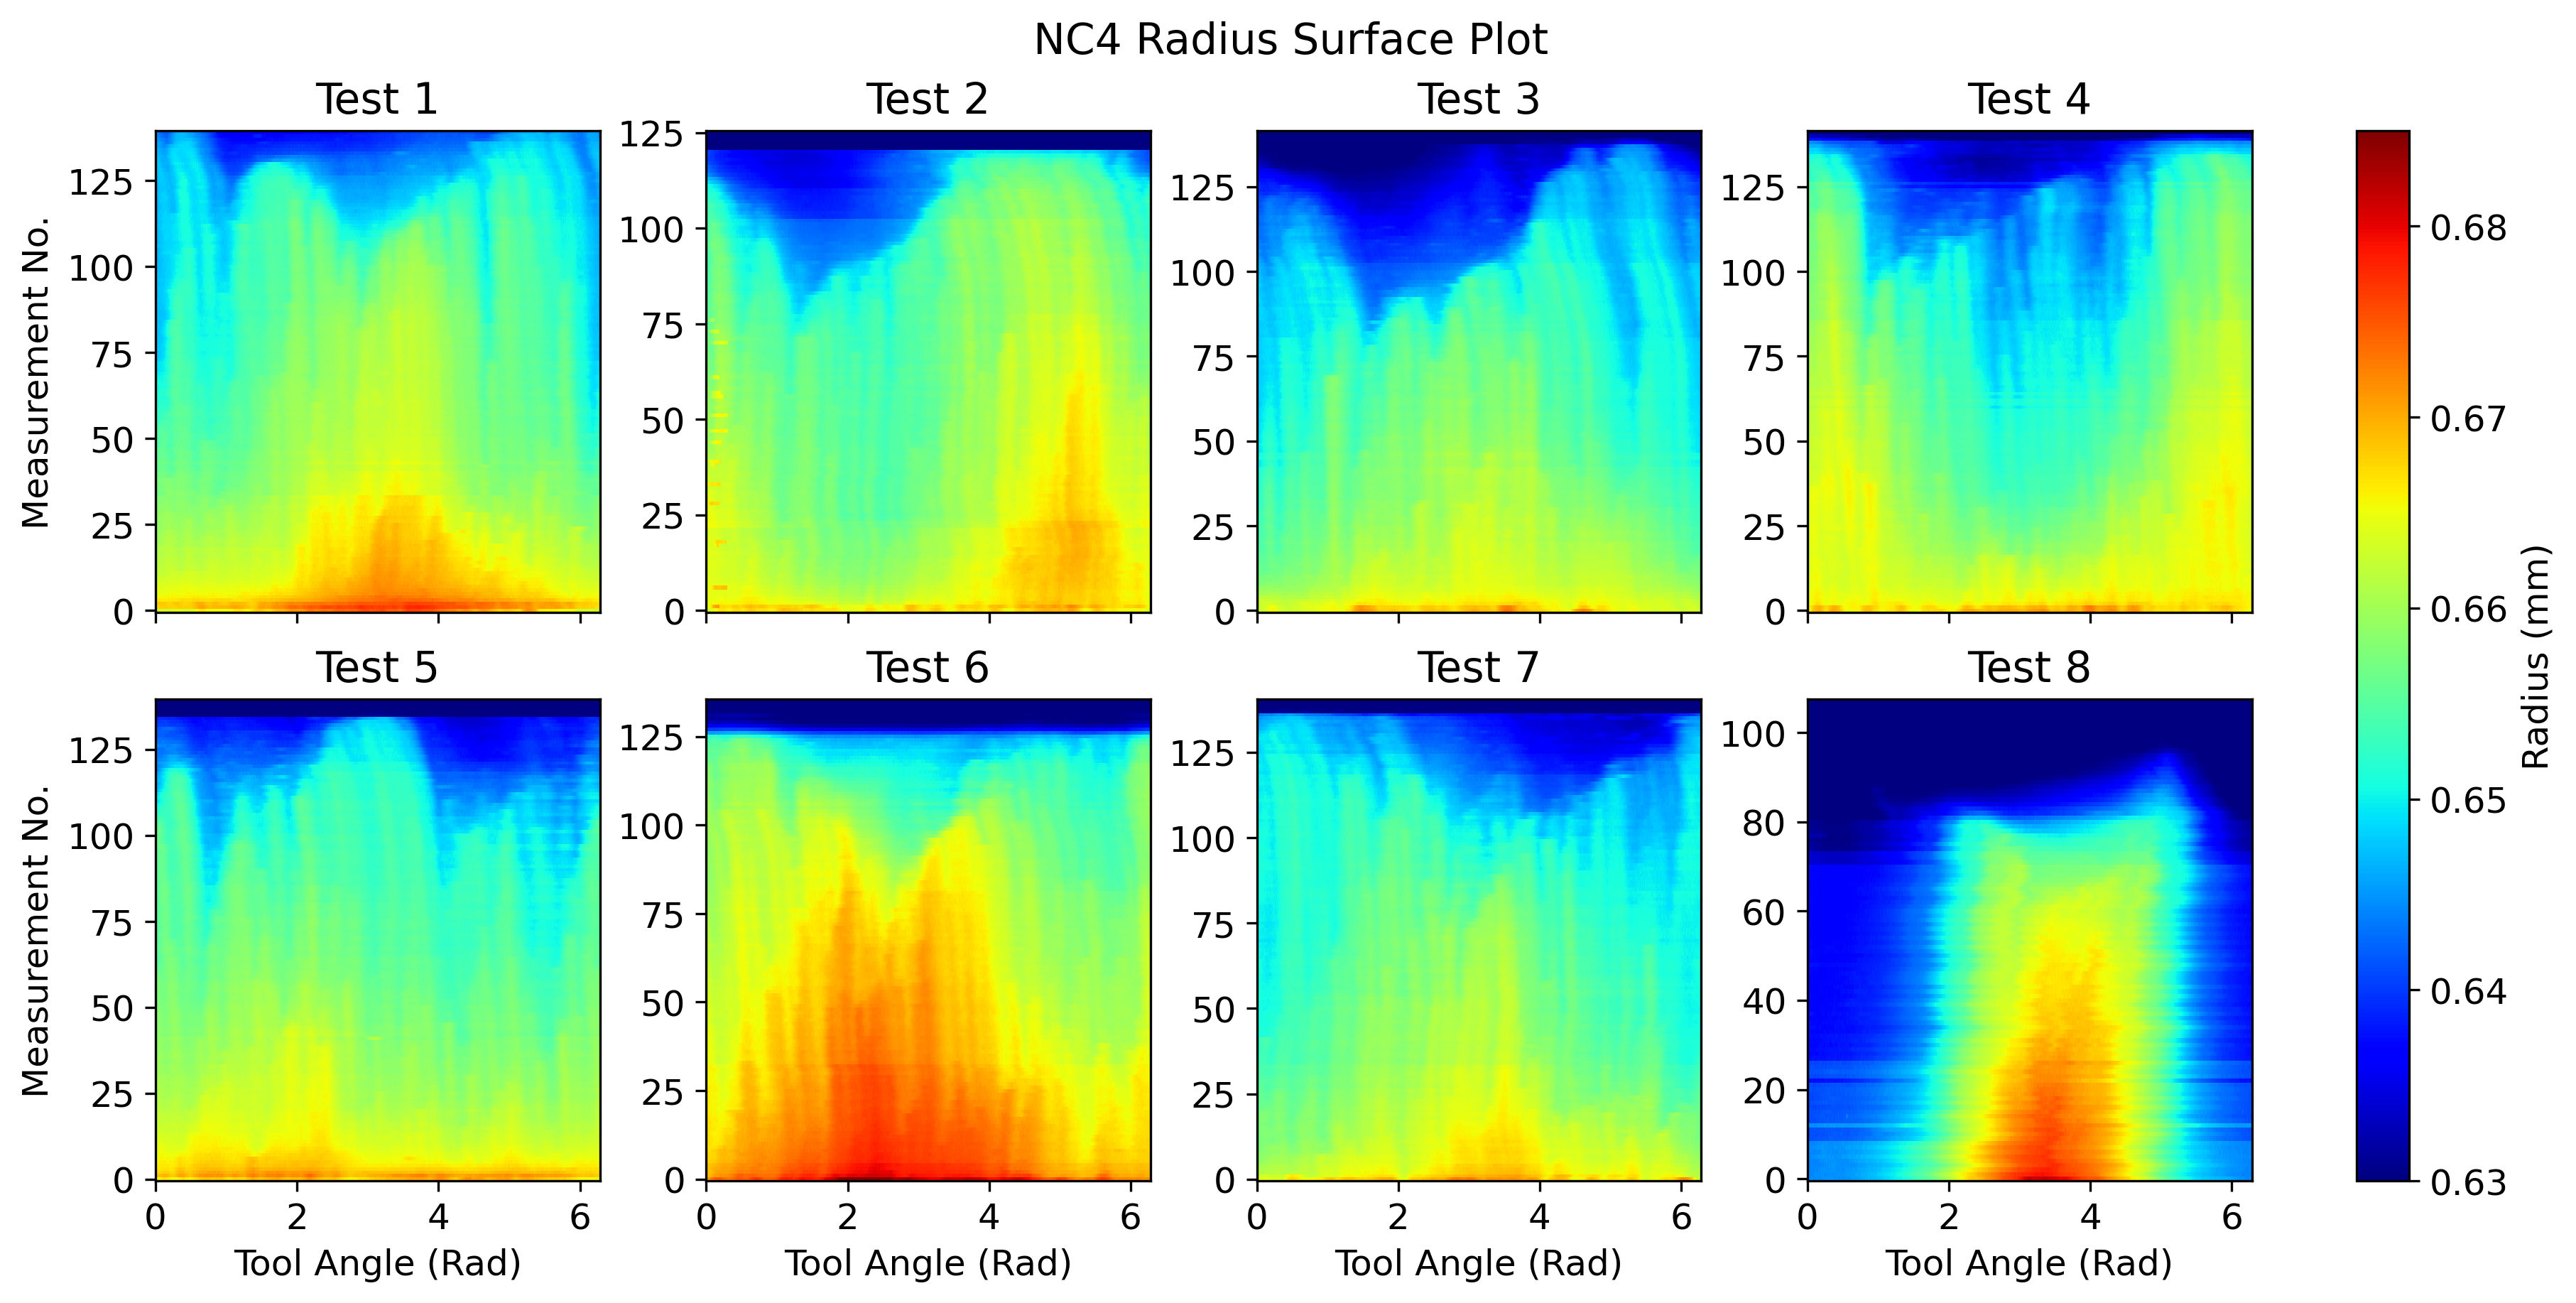

In [6]:
fig, ax = plt.subplots(2, 4,
                       figsize=(12, 6),
                       dpi=300,
                       constrained_layout=True,
                       sharex='col',
                       )

fig.suptitle('NC4 Radius Surface Plot')
# fig.supxlabel('Angle (rad)')
# fig.supylabel('Measurement No.')

axes = fig.axes

cutoffs = [
    (None, None),
    (None, None),
    (None, None),
    (None, None),
    (None, None),
    (None, None),
    (None, None),
    (None, None),
]

vmin = 0.63; vmax = 0.685

for i, exp in enumerate(exps):
    slice_n = slice(cutoffs[i][0], cutoffs[i][1])
    r = np.array(exp.nc4.radius[slice_n], dtype=float)
    x = np.array(exp.nc4.theta, dtype=float)
    y = np.array(exp.nc4._datano[slice_n], dtype=float)
    surf = axes[i].pcolormesh(x,
                              y,
                              r,
                              cmap='jet',
                              rasterized=True,
                              shading='nearest',
                              vmin=vmin,
                              vmax=vmax
                              )
    if i > 3:
        axes[i].set_xlabel('Tool Angle (Rad)')
    if i == 0 or i == 4:
        axes[i].set_ylabel('Measurement No.')
    axes[i].set_title(f'Test {i+1}')
fig.colorbar(surf, ax=axes, label='Radius (mm)')

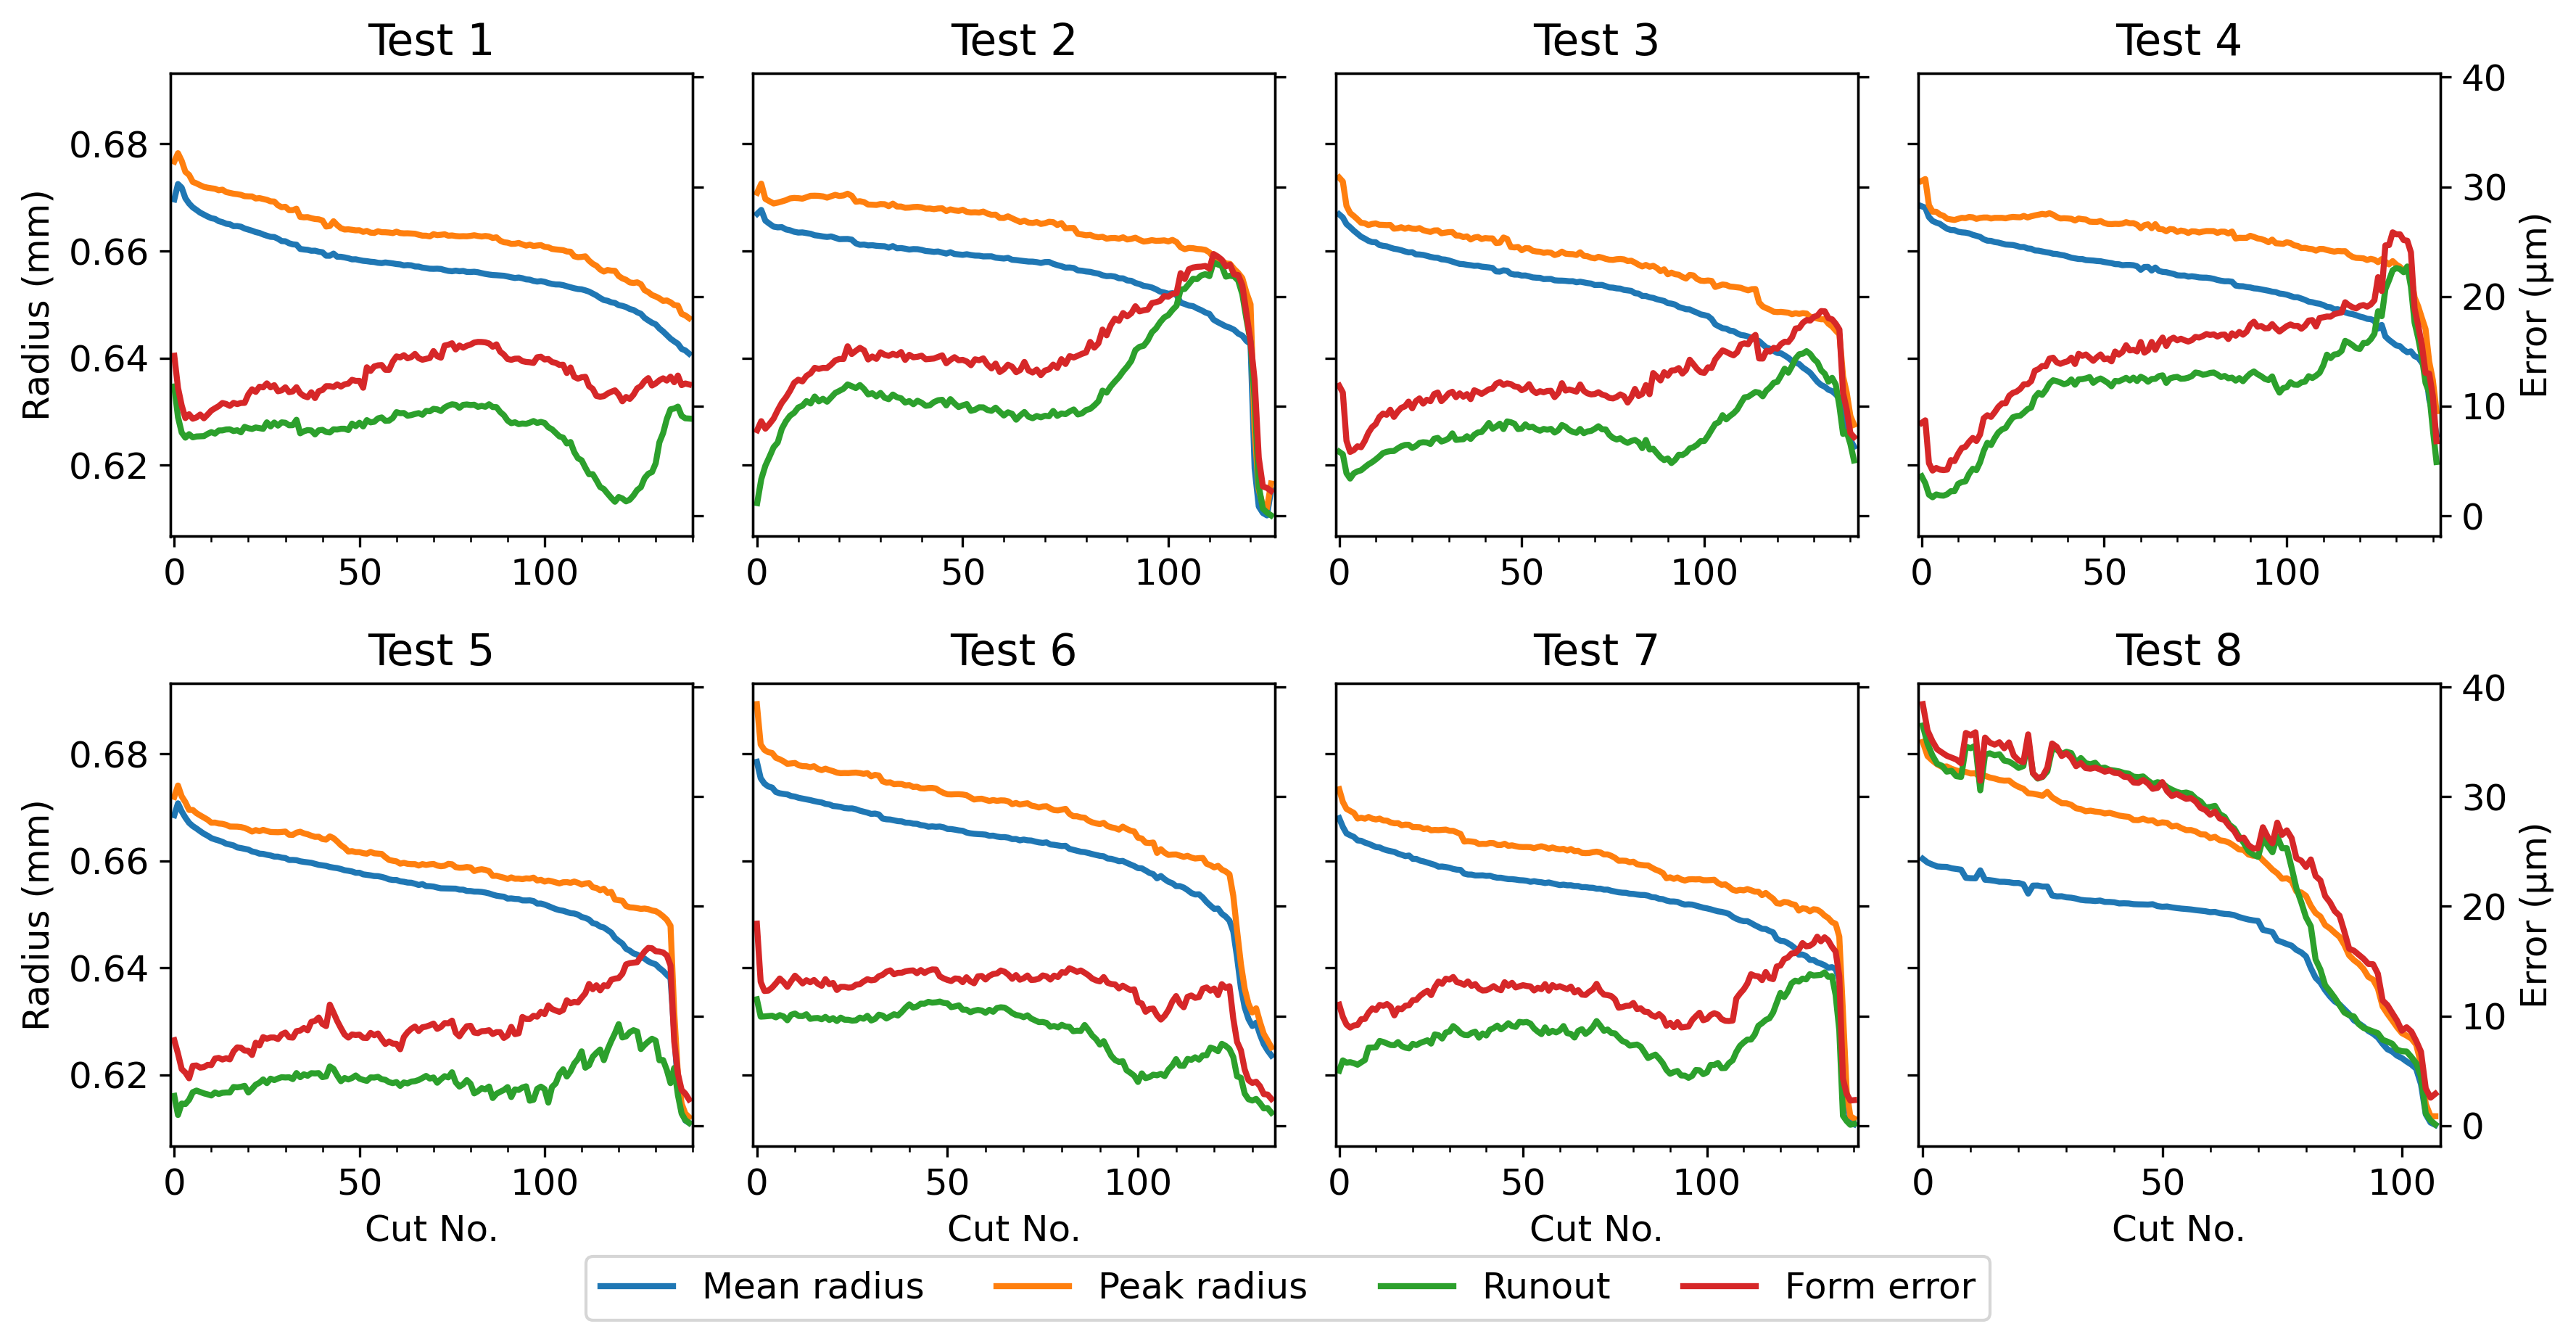

In [7]:
fig, ax = plt.subplots(2, 4,
                       figsize=(12, 6),
                       sharey=True,
                       dpi=300,
                       )
axis_r = []
axis_e = []

ax = ax.ravel()

for a in ax:
    axis_r.append(a)
    axis_e.append(a.twinx())

for ax1, ax2 in zip(axis_e[1:], axis_e[0:-1]):
    ax1.sharey(ax2)

ax = zip(axis_r, axis_e)

for i, (exp, (ax_r, ax_e)) in enumerate(zip(exps, ax)):
    # lstyle = itertools.cycle(['-', (0, (5, 1)), ':', (0, (3, 1, 1, 1,))])
    lstyle = itertools.cycle(['-'])
    lcolor = itertools.cycle(['C0', 'C1', 'C2', 'C3'])
    for data in data_names[:2]:
        lab = data.replace('_', ' ').capitalize()
        ax_r.plot(getattr(exp.nc4, data), 
                  linestyle=next(lstyle), 
                  color=next(lcolor),
                  linewidth=2, 
                  label=lab
                  )
    for data in data_names[2:]:
        lab = data.replace('_', ' ').capitalize()
        ax_e.plot(getattr(exp.nc4, data) * 1000, 
                  linestyle=next(lstyle), 
                  color=next(lcolor), 
                  linewidth=2, 
                  label=lab
                  )

    ax_r.set_title(f'Test {i+1}')
    ax_r.set_xlim(-1, len(getattr(exp.nc4, data)))
    if i > 3:
        ax_r.set_xlabel('Cut No.')
    ax_r.xaxis.set_major_locator(MultipleLocator(50))
    ax_r.xaxis.set_minor_locator(MultipleLocator(10))
    l1, lab1 = ax_r.get_legend_handles_labels()
    l2, lab2 = ax_e.get_legend_handles_labels()

axis_r[0].set_ylabel('Radius (mm)')
axis_r[4].set_ylabel('Radius (mm)')
axis_e[3].set_ylabel('Error (\u03BCm)')
axis_e[-1].set_ylabel('Error (\u03BCm)')


for i, a in enumerate(axis_e):
    if i == 3 or i == 7:
        continue
    plt.setp(a.get_yticklabels(), visible=False)

plt.figlegend(l1 + l2,
              lab1 + lab2, 
              loc='center', 
              bbox_to_anchor=(0.5, 0), 
            #   bbox_transform=fig.transfigure, 
              ncol=4
              )
fig.tight_layout()

## PROBE

In [6]:
def _smooth(sig, win=11):
    """
    Smooth signal using a moving average filter.

    Replicates MATLAB's smooth function. (http://tinyurl.com/374kd3ny)

    Args:
        sig (np.array): Signal to smooth.
        win (int, optional): Window size. Defaults to 11.

    Returns:
        np.array: Smoothed signal.
    """
    out = np.convolve(sig, np.ones(win, dtype=int), 'valid') / win
    r = np.arange(1, win - 1, 2)
    start = np.cumsum(sig[:win - 1])[::2] / r
    stop = (np.cumsum(sig[:-win:-1])[::2] / r)[::-1]
    return np.concatenate((start, out, stop))

In [7]:
doc = 0.03 * 1000    # Depth of cut (mm)
tol = 0.0015 * 1000   # Tolerance (mm)
overall_tol = 0.02 # Overall tolerance (mm)

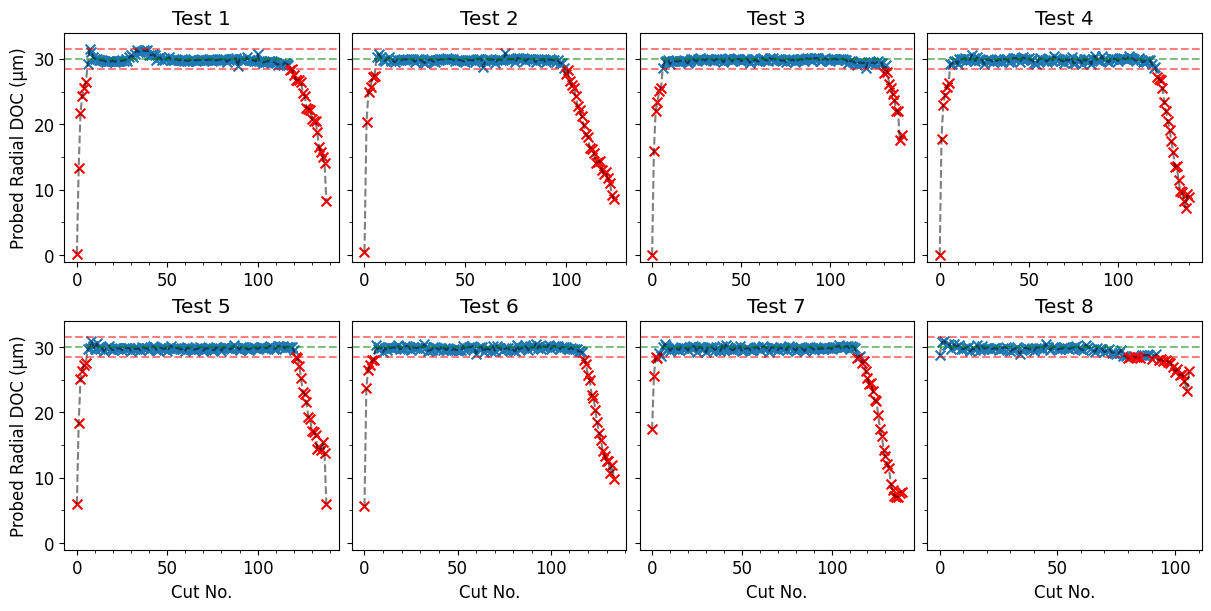

In [16]:
fig, ax = plt.subplots(2, 4,
                       figsize=(12, 6),
                       sharey='row',
                       constrained_layout=True,
                       )

ax = ax.ravel()

for i, exp in enumerate(exps):
    y = exp.probe.probeData['PROBEDIFF'].iloc[1:].values * 1000
    y[y < 0] = 0
    x = np.arange(len(y))

    y_smooth = y
    y_smooth = _smooth(y, win=11)

    tol_bool = [0 if doc - tol <= x <= doc + tol else 1 for x in y_smooth]
    tol_bool = np.array(tol_bool).astype(bool)

    in_tol = y_smooth.copy()
    in_tol[tol_bool] = np.nan

    out_tol = y_smooth.copy()
    out_tol[~tol_bool] = np.nan

    ax[i].scatter(x, in_tol, color='C0', marker='x', s=50)
    ax[i].scatter(x, out_tol, color='r', marker='x', s=50)
    ax[i].plot(x, y_smooth, color='k', alpha=0.5, linestyle='--')
    ax[i].set_ylim(-1, 34)

    ax[i].set_title(f'Test {i+1}')
    if i > 3:
        ax[i].set_xlabel('Cut No.')
    if i == 0 or i == 4:
        ax[i].set_ylabel('Probed Radial DOC (\u03BCm)')
    ax[i].yaxis.set_major_locator(MultipleLocator(10))
    ax[i].yaxis.set_minor_locator(MultipleLocator(5))
    ax[i].xaxis.set_major_locator(MultipleLocator(50))
    ax[i].xaxis.set_minor_locator(MultipleLocator(10))

    ax[i].axhline(doc, color='g', ls='--', alpha=0.5)
    ax[i].axhline(doc - tol, color='r', ls='--', alpha=0.5)
    ax[i].axhline(doc + tol, color='r', ls='--', alpha=0.5)


## AE

Text(-0.06, 1.02, '(b)')

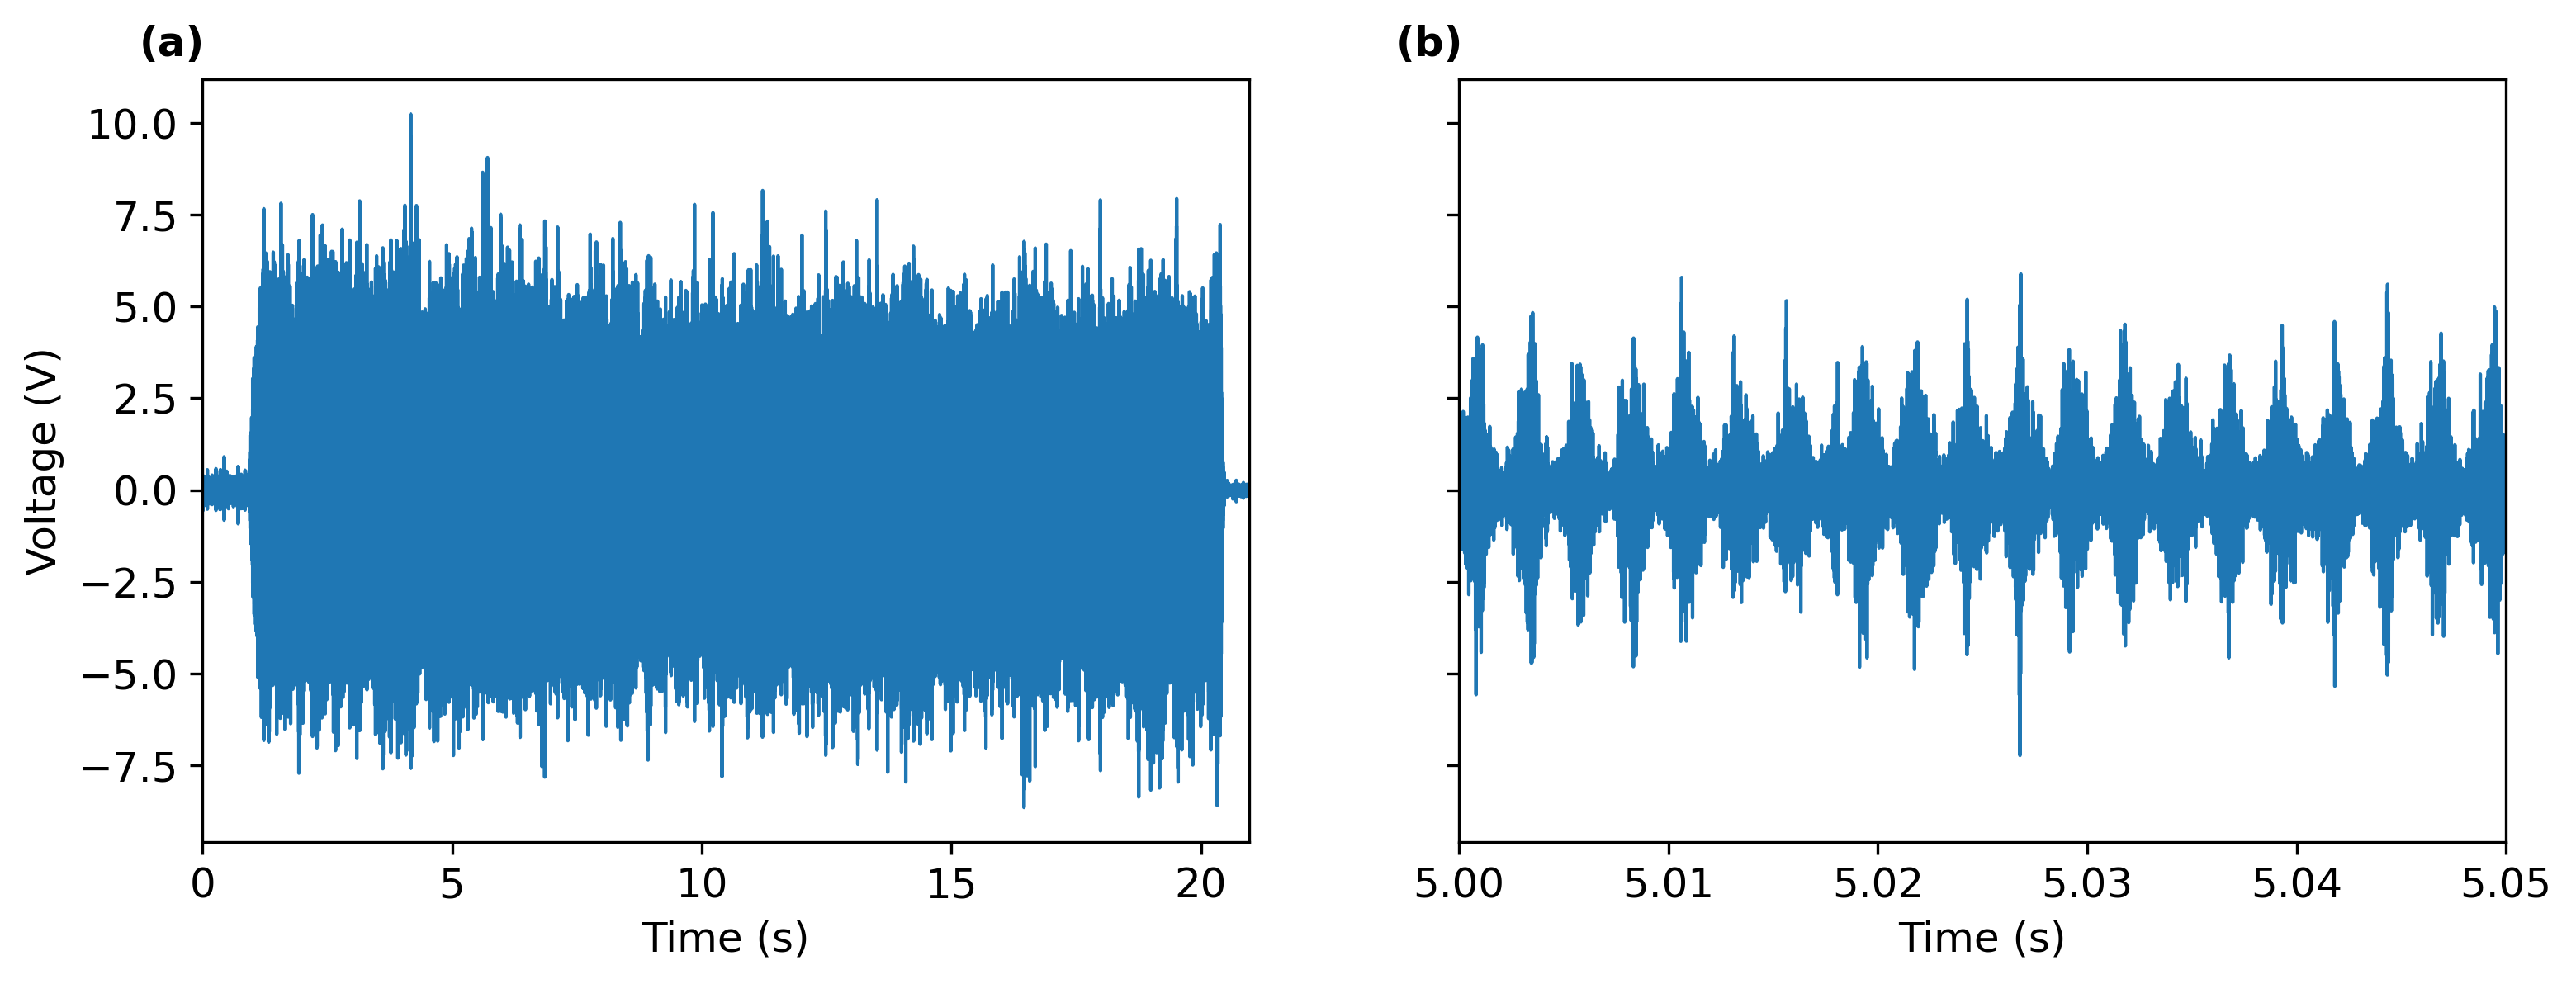

In [11]:
fig, ax = plt.subplots(1, 2,
                       sharey=True,
                       figsize=(12, 4),
                       dpi=300,
                       )

fig, ax[0] = exps[0].ae.plotAE(10, ax=ax[0])
# ax[0].set_xlim([1.05, 1.2])
# ax[0].axvline(exps[0].ae.trig_points['trig st'][10] * (1 / exps[0].ae._fs),
#               alpha=0.5,
#               color='r',
#               linestyle='--',
#               )
# ax[0].axvline(exps[0].ae.trig_points['trig end'][10] * (1 / exps[0].ae._fs),
#               alpha=0.5,
#               color='r',
#               linestyle='--',
#               )
ax[0].set_title('')
ax[0].text(-0.06, 1.02, '(a)', transform=ax[0].transAxes,fontweight='bold', va='bottom', ha='left')

fig, ax[1] = exps[0].ae.plotAE(10, ax=ax[1])
ax[1].set_xlim([5, 5.05])
# ax[1].axvline(exps[0].ae.trig_points['trig st'][10] * (1 / exps[0].ae._fs),
#               alpha=0.5,
#               color='r',
#               linestyle='--',
#               )
ax[1].set_title('')
ax[1].set_ylabel('')
ax[1].text(-0.06, 1.02, '(b)', transform=ax[1].transAxes, fontweight='bold', va='bottom', ha='left')

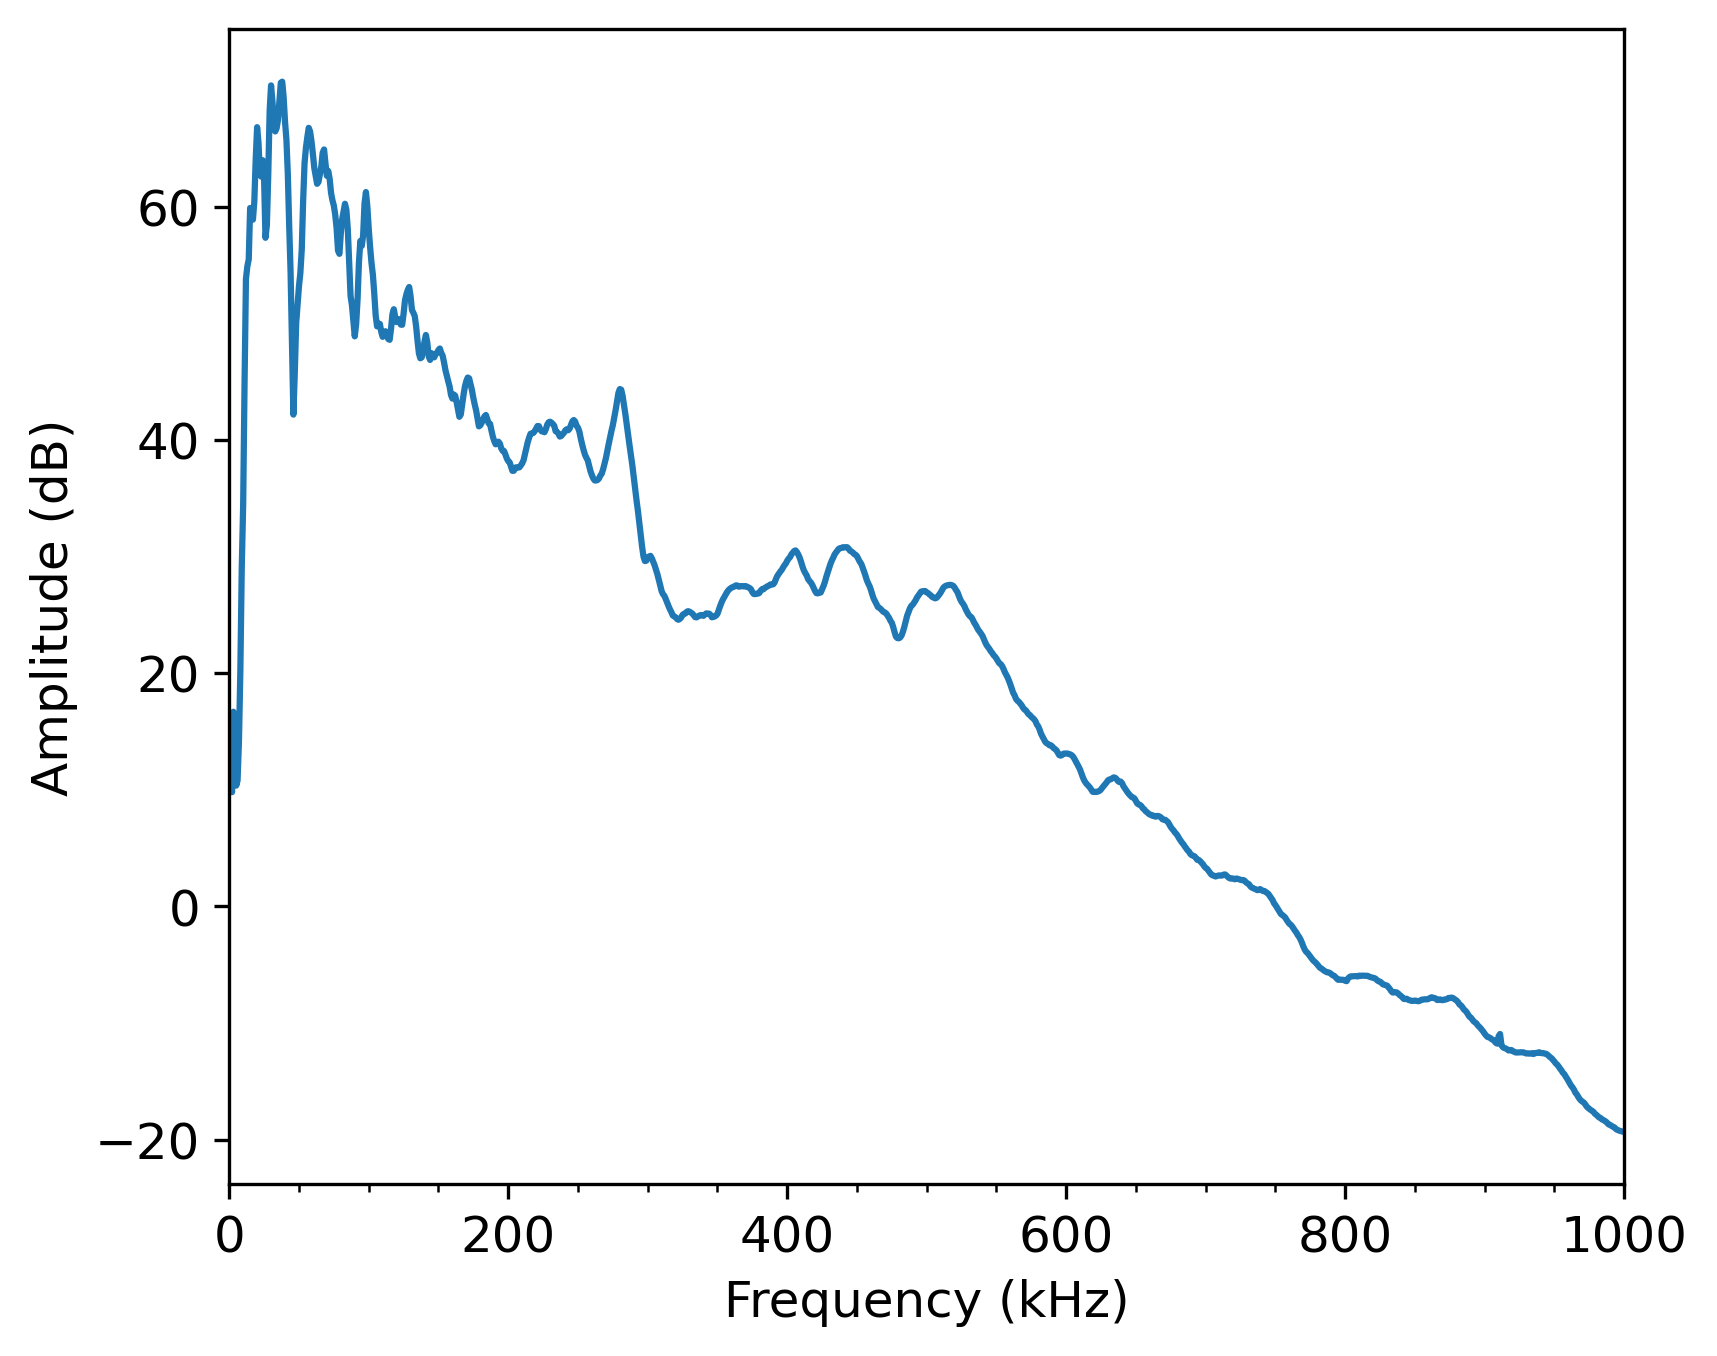

In [12]:
def fft(exp, fno, ax, freqres=1000):

    if freqres in exp.ae.fft:
        p = exp.ae.fft[freqres][fno]
    else:
        p = exp.ae._fftcalc(fno, freqres)
    f = np.arange(0, exp.ae._fs / 2, freqres, dtype=int)

    l = ax.plot(f / 1000, p)
    ax.autoscale(enable=True, axis='x', tight=True)
    ax.set_xlabel('Frequency (kHz)')
    ax.set_ylabel('Amplitude (dB)')
    return ax, l

fig, ax = plt.subplots(figsize=(6, 5), dpi=300)
l = []
lab = []
for i, exp in enumerate(exps[:1]):
    ax, l1 = fft(exp, 10, ax)
    l += l1
    lab.append(f'Test {i+1}')
# ax.legend(l, lab, fontsize=10)
ax.set_xticks(np.arange(0, 1200, 200))
ax.xaxis.set_minor_locator(MultipleLocator(50))
# ax.grid(visible=True, axis='both', which='major')

Text(0.5, 1.0, '')

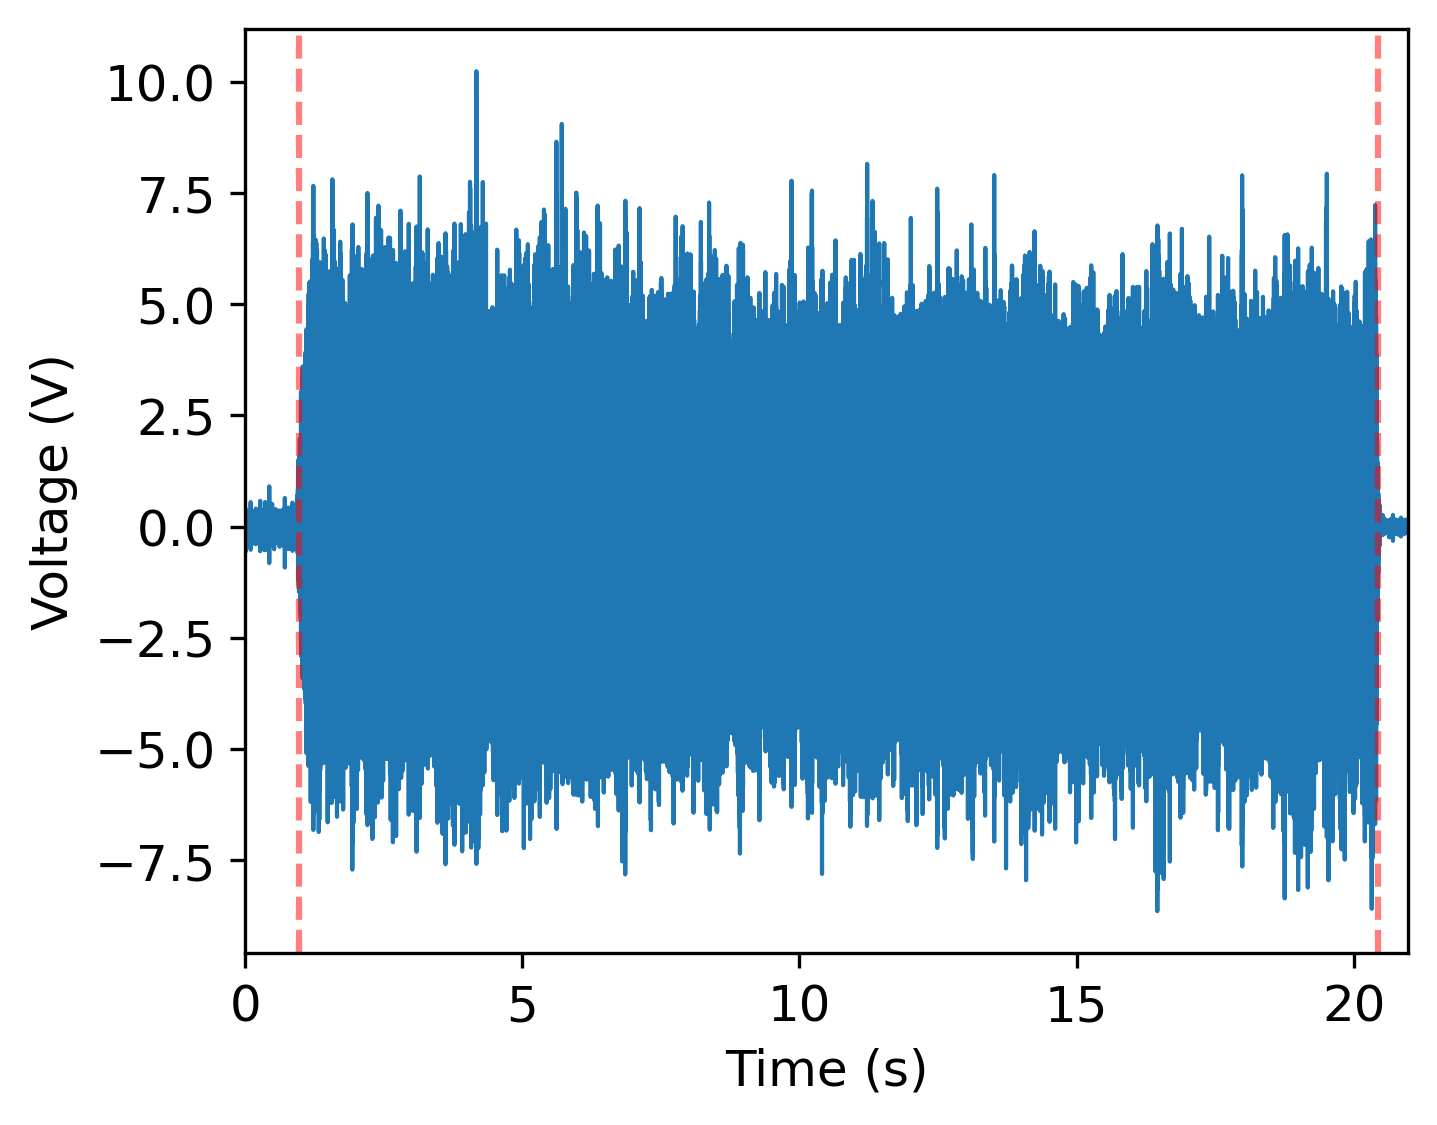

In [28]:
fig, ax = plt.subplots(1, 1,
                       sharey=True,
                       figsize=(5, 4),
                       dpi=300,
                       )

fig, ax = exps[0].ae.plotAE(10, ax=ax)
ax.axvline(exps[0].ae.trig_points['trig st'][10] * (1 / exps[0].ae._fs),
              alpha=0.5,
              color='r',
              linestyle='--',
              )
ax.axvline(exps[0].ae.trig_points['trig end'][10] * (1 / exps[0].ae._fs),
              alpha=0.5,
              color='r',
              linestyle='--',
              )
ax.set_title('')

Text(0.5, 1.0, '')

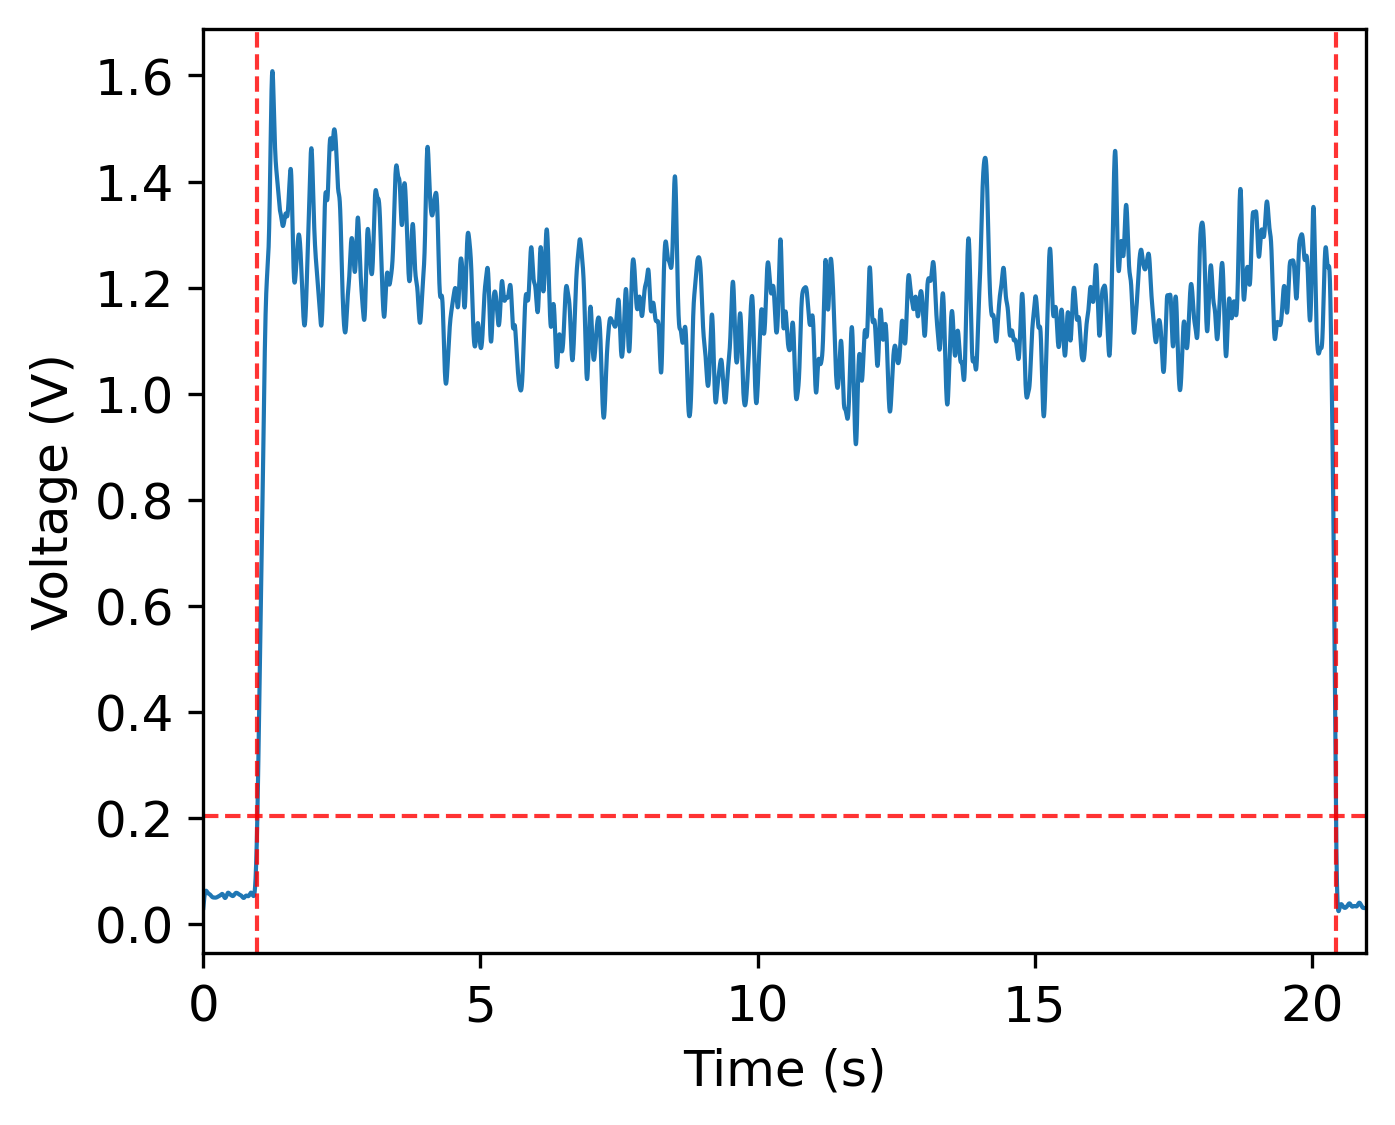

In [29]:
fig, ax = plt.subplots(1, 1,
                       figsize=(5, 4),
                       dpi=300,
                       )
fig, ax = exps[0].ae.plot_triggers(10, ax=ax)
ax.set_title('')

## AE Features

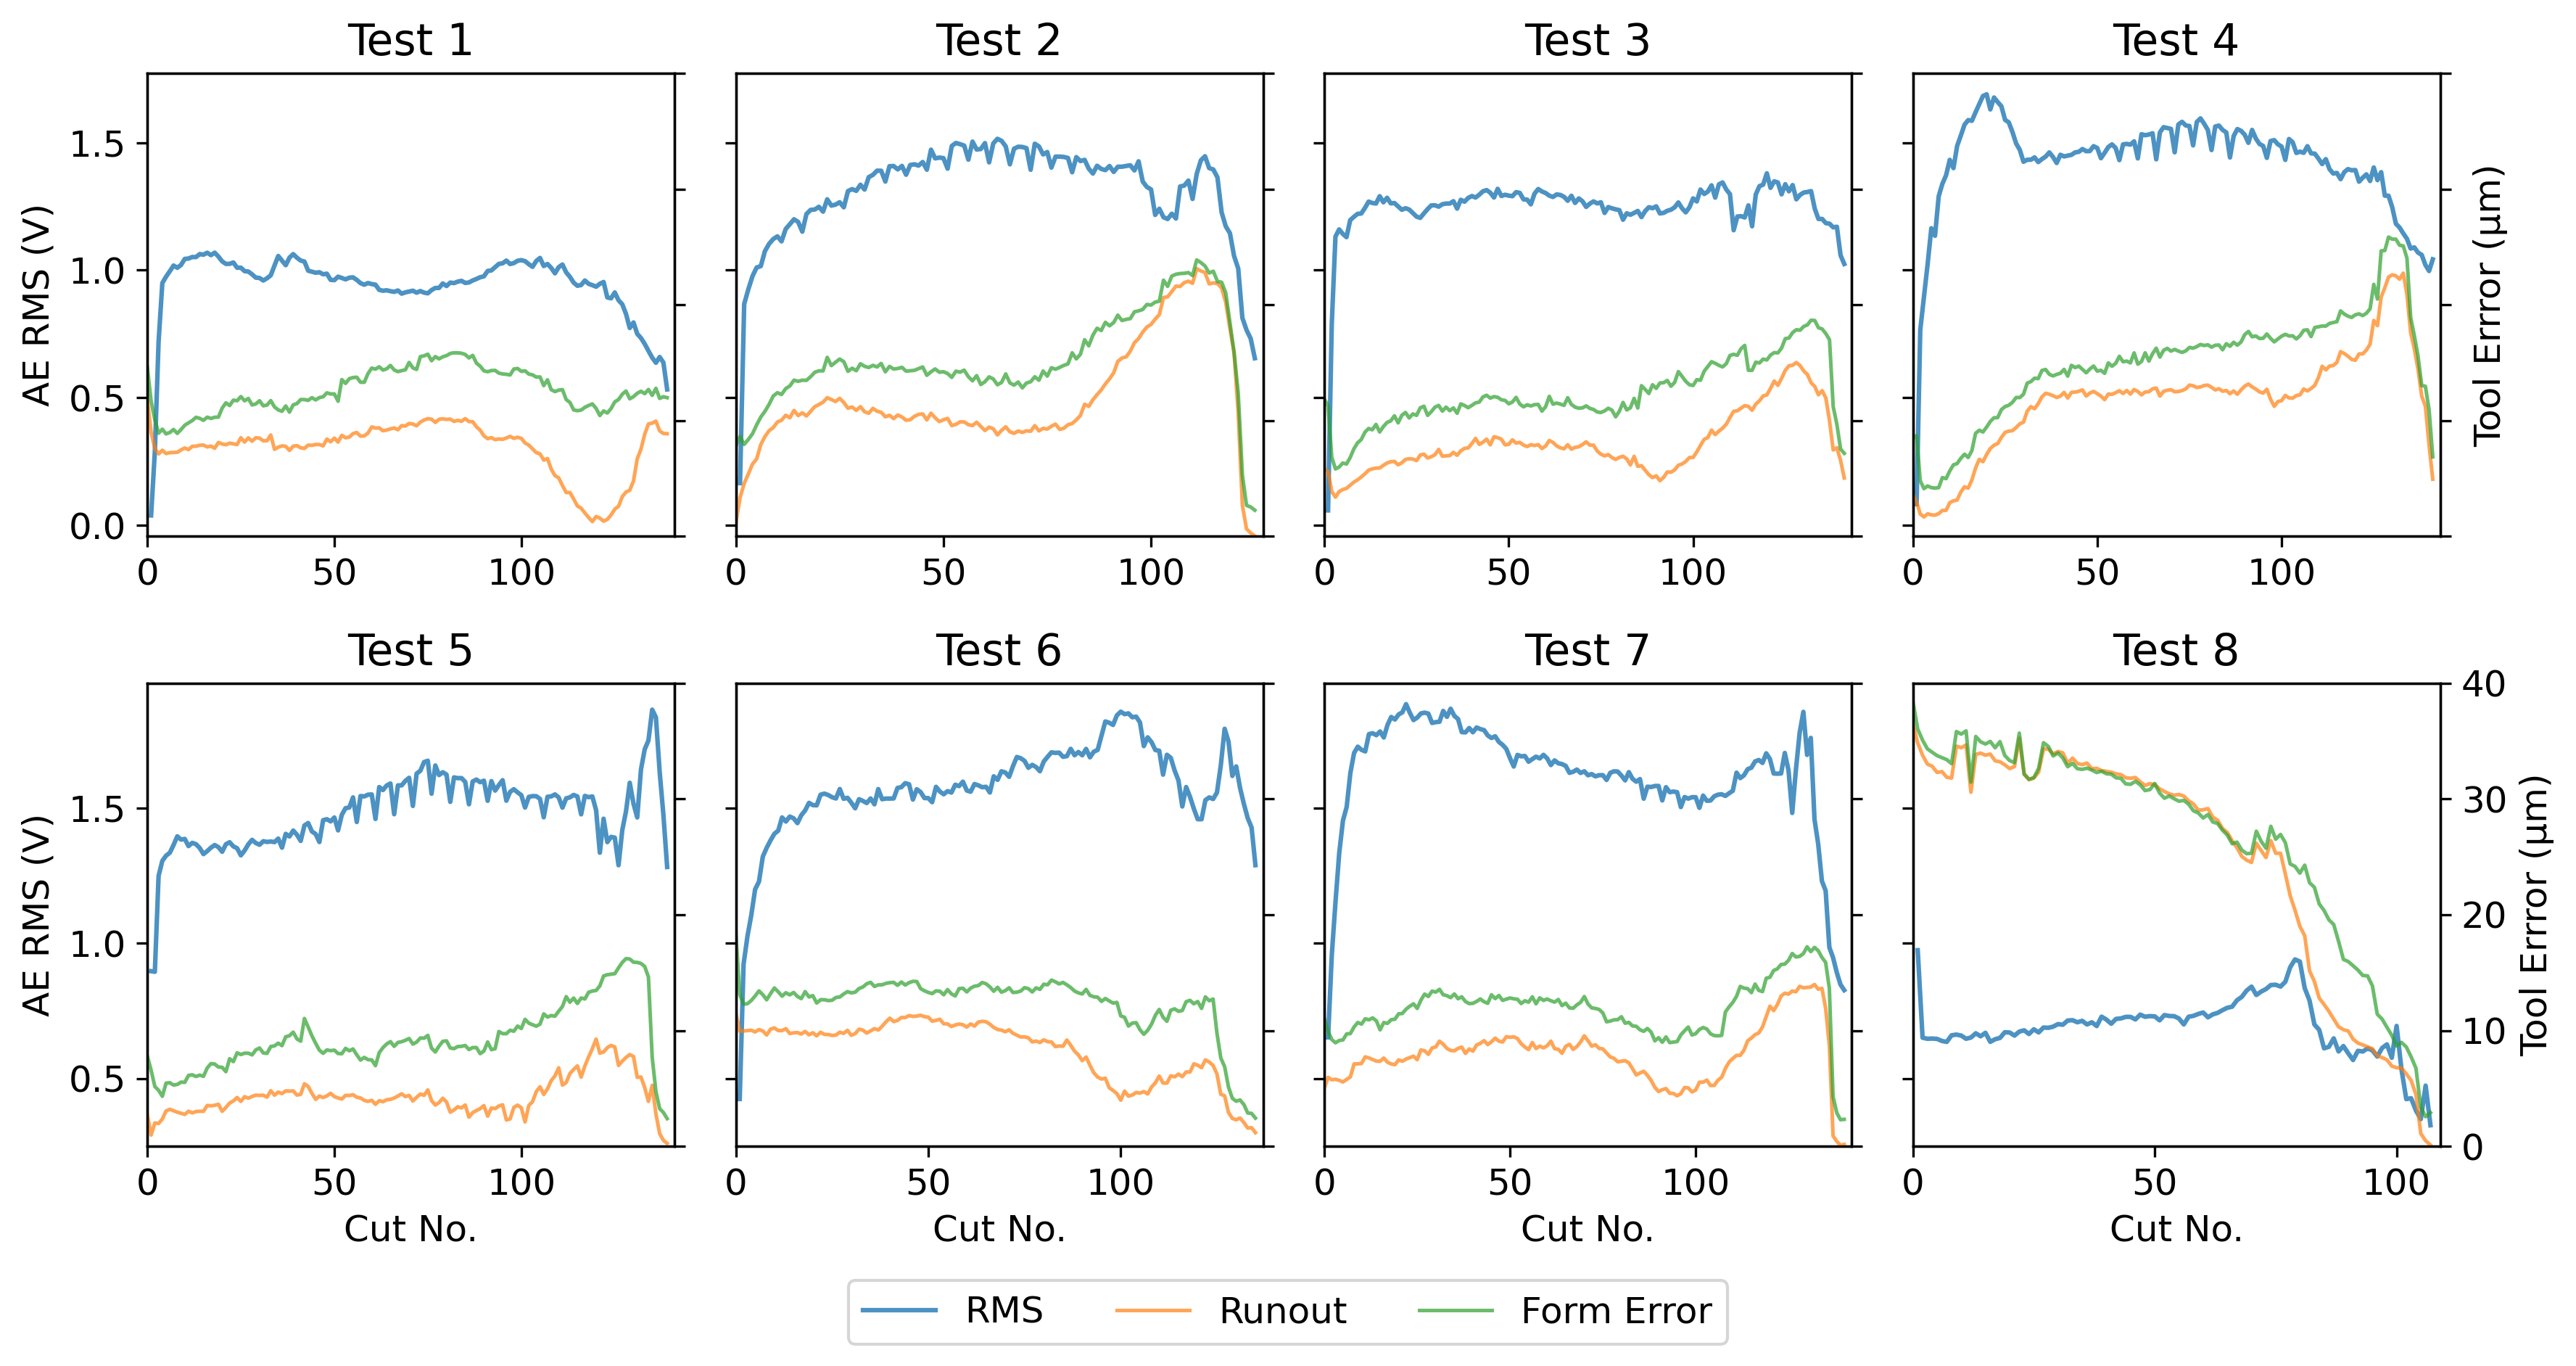

In [15]:
fig, ax = plt.subplots(2, 4,
                       figsize=(12, 6),
                       dpi=300,
                       constrained_layout=True,
                       sharey='row',
                       )
ax = ax.ravel()

for i, exp in enumerate(exps):
    kurt_line = ax[i].plot(exp.features['RMS'],
                           'C0',
                           label='RMS',
                           alpha=0.8,
                           linewidth=1.5,
                           )
    
    # ax[i].set_ylim(0, 20)
    
#     ax[i].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[i].set_xlim(0, len(exp.features['RMS']) + 1)
#     ax[i].set_ylim(0, 14)

    ax2 = ax[i].twinx()
#     ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    runout_line = ax2.plot(exp.features['Runout'],
                           'C1',
                           label='Runout',
                           alpha=0.7,
                           linewidth=1.2,
                           )
    formerror_line = ax2.plot(exp.features['Form error'],
                              'C2',
                              label='Form Error',
                              alpha=0.7,
                              linewidth=1.2,
                              )
    
    ax2.set_ylim(0, 40)
    if i > 3:
        ax[i].set_xlabel('Cut No.')

    ax[i].set_title(f'Test {i+1}')
    if i == 0 or i == 4:
        ax[i].set_ylabel('AE RMS (V)')
    if i == 7 or i == 3:
        ax2.set_ylabel('Tool Errror (\u03BCm)')
    if i < len(exps) - 1:
        ax2.set_yticklabels([])

lns = kurt_line + runout_line + formerror_line
labs = [l.get_label() for l in lns]
fig.legend(lns, labs, loc='upper center', bbox_to_anchor=(0.5, 0.02), ncol=3)
fig.tight_layout()

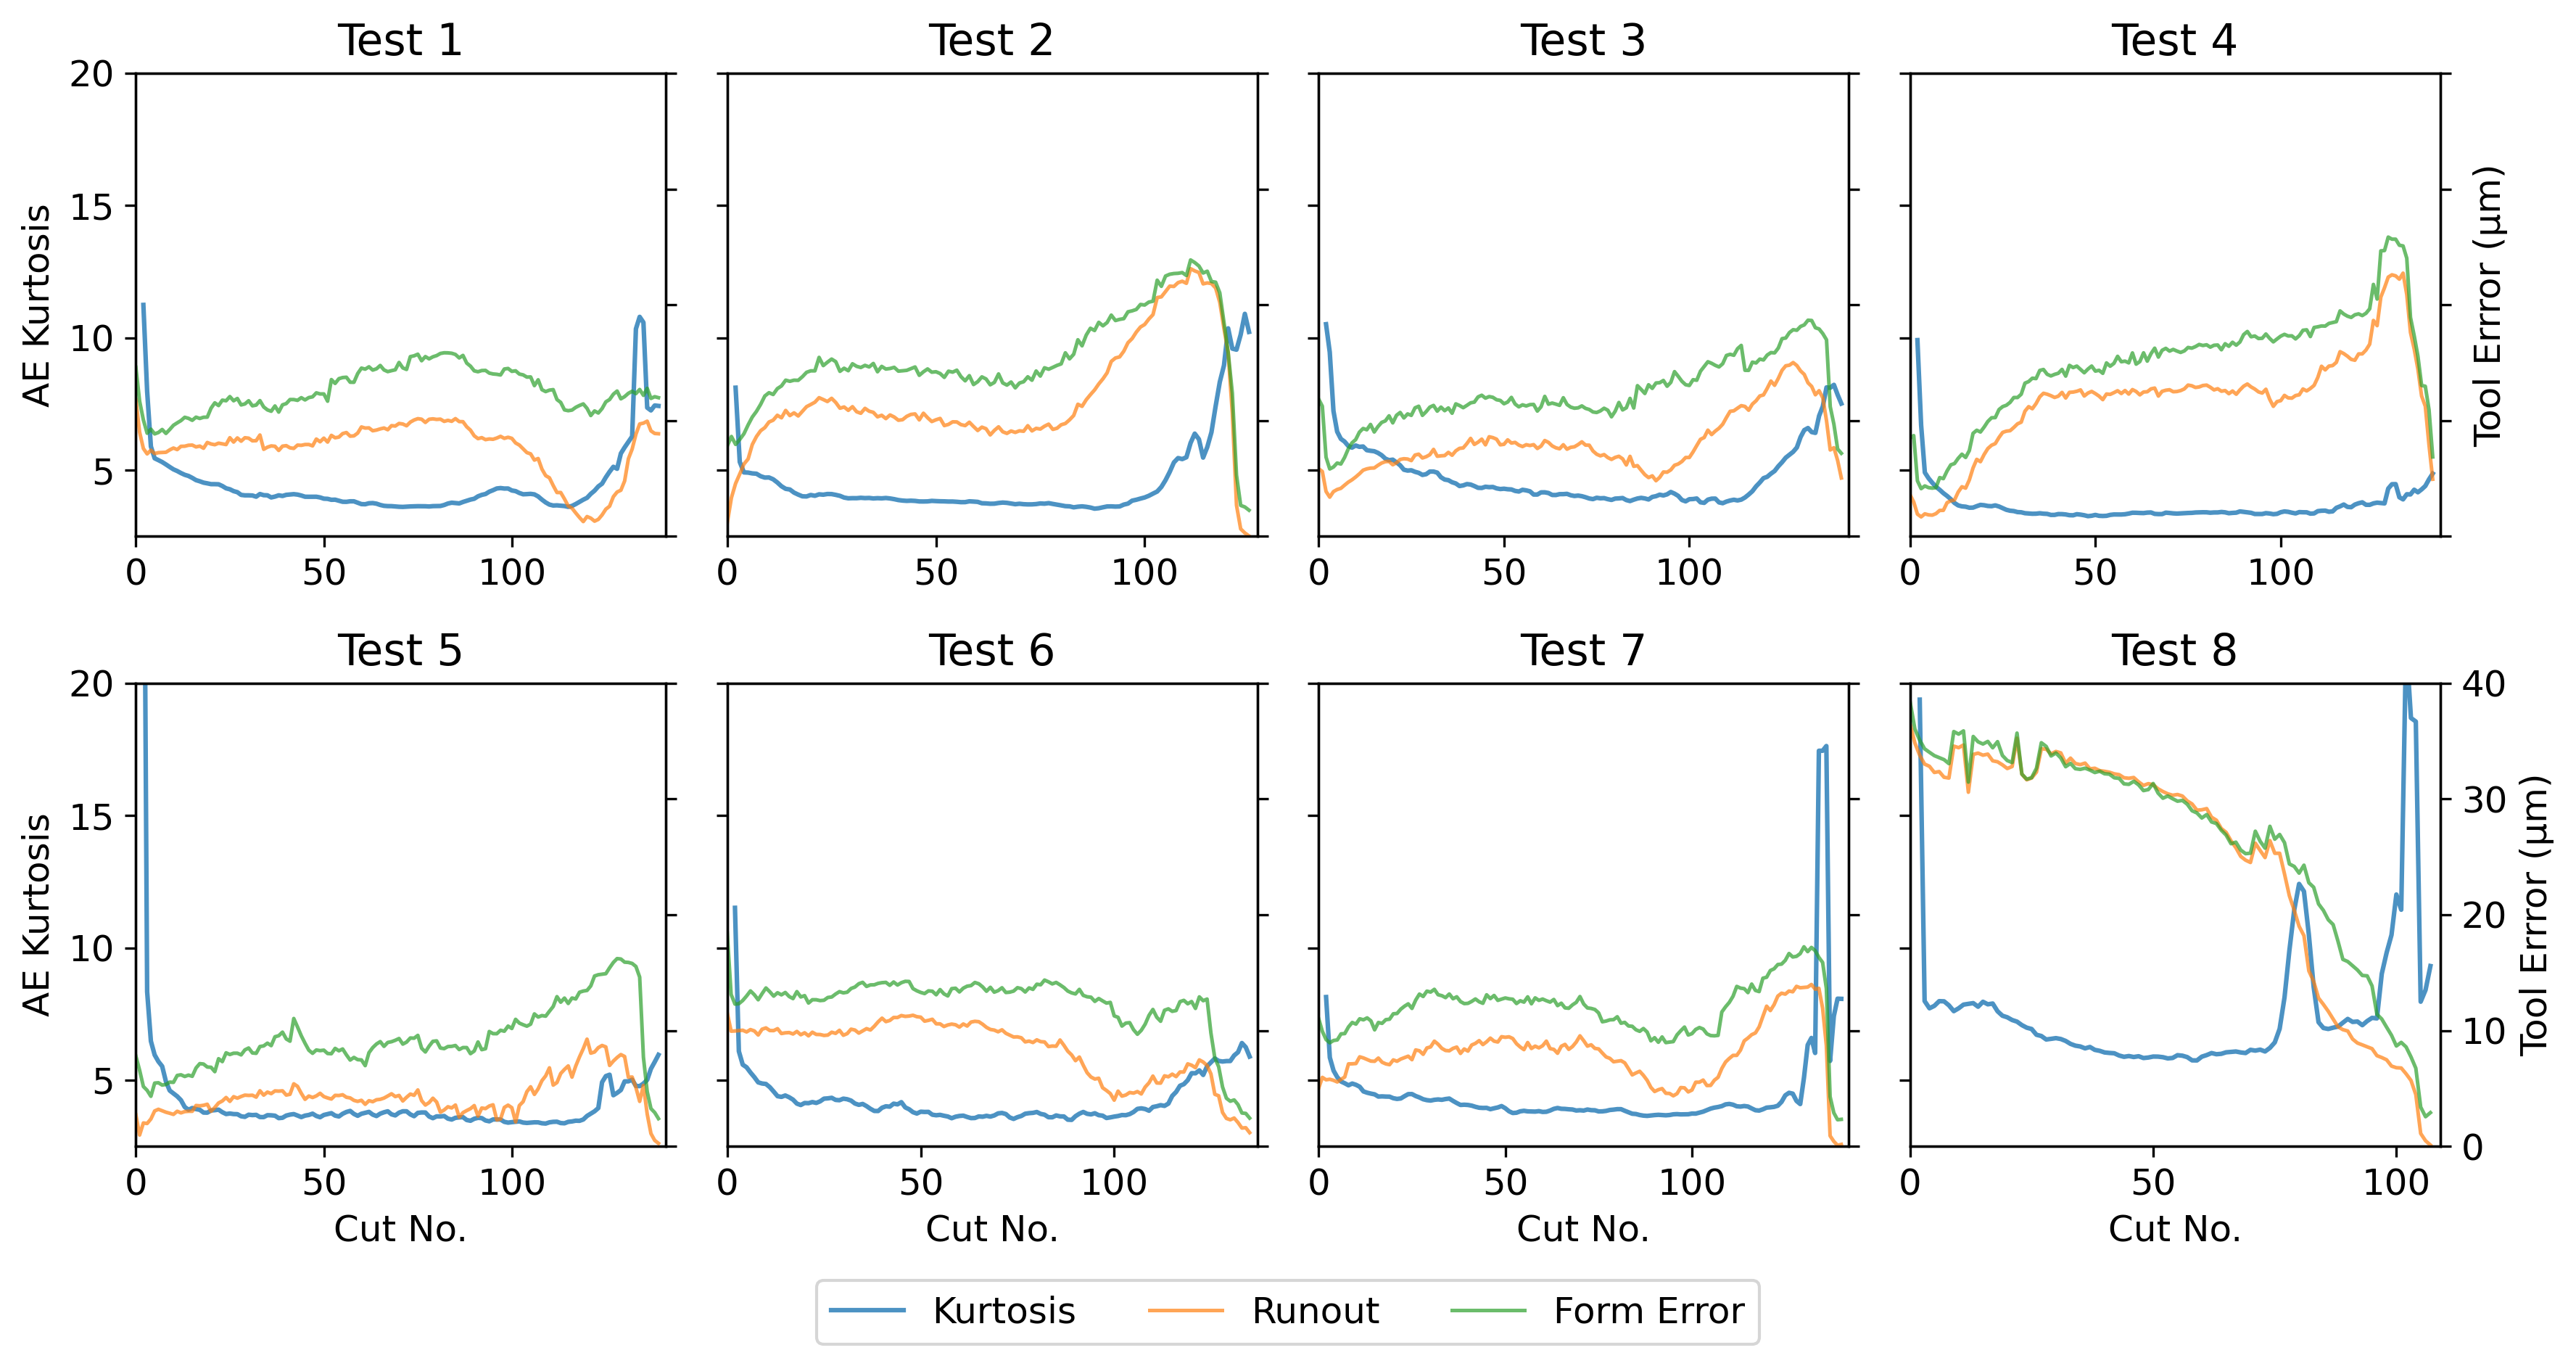

In [16]:
fig, ax = plt.subplots(2, 4,
                       figsize=(12, 6),
                       dpi=300,
                       constrained_layout=True,
                       sharey='row',
                       )
ax = ax.ravel()

for i, exp in enumerate(exps):
    kurt_line = ax[i].plot(_smooth(exp.features['Kurtosis'], win=3),
                           'C0',
                           label='Kurtosis',
                           alpha=0.8,
                           linewidth=1.5,
                           )
    
#     ax[i].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[i].set_xlim(0, len(exp.features['Kurtosis']) + 1)

    ax2 = ax[i].twinx()
#     ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    runout_line = ax2.plot(exp.features['Runout'],
                           'C1',
                           label='Runout',
                           alpha=0.7,
                           linewidth=1.2,
                           )
    formerror_line = ax2.plot(exp.features['Form error'],
                              'C2',
                              label='Form Error',
                              alpha=0.7,
                              linewidth=1.2,
                              )
    
    ax[i].set_ylim(2.5, 20)
    ax2.set_ylim(0, 40)

    ax[i].set_title(f'Test {i+1}')
    if i > 3:
        ax[i].set_xlabel('Cut No.')
    if i == 0 or i == 4:
        ax[i].set_ylabel('AE Kurtosis')
    if i == 7 or i == 3:
        ax2.set_ylabel('Tool Errror (\u03BCm)')
    if i < len(exps) - 1:
        ax2.set_yticklabels([])

lns = kurt_line + runout_line + formerror_line
labs = [l.get_label() for l in lns]
fig.legend(lns, labs, loc='upper center', bbox_to_anchor=(0.5, 0.02), ncol=3)
fig.tight_layout()

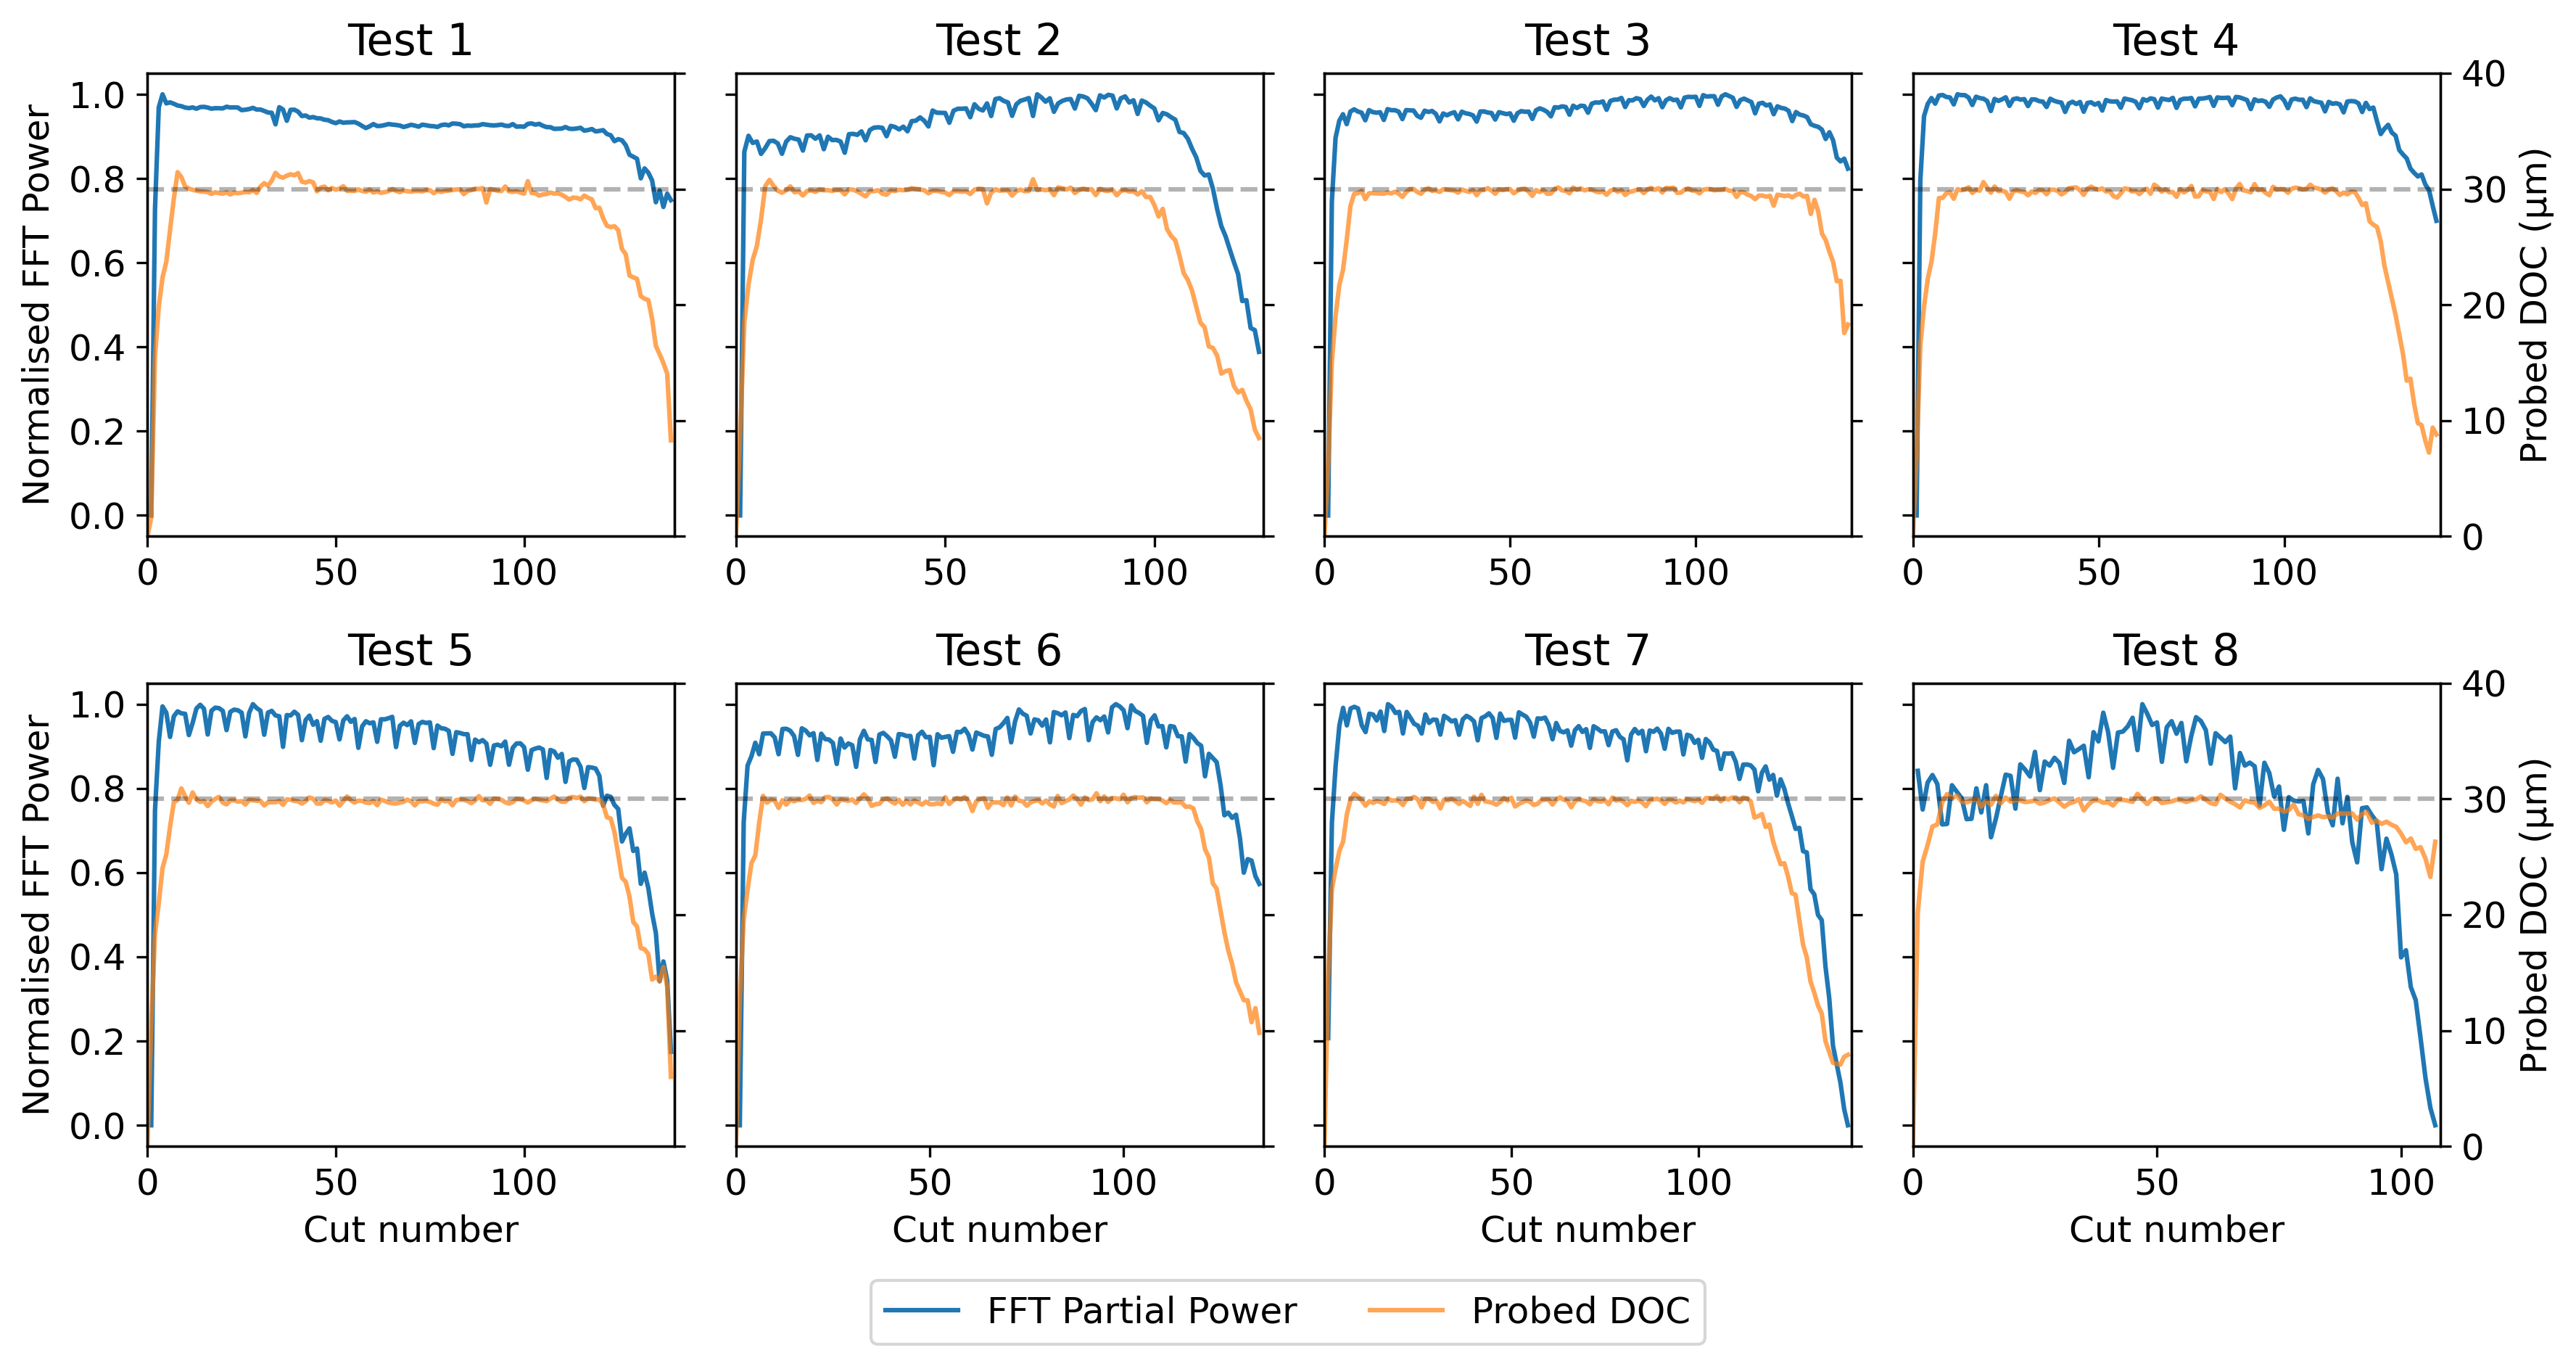

In [17]:
freq = 35

fig, ax = plt.subplots(2, 4, figsize=(12, 6), sharey='row', dpi=300)
ax = ax.ravel()
for i, exp in enumerate(exps):
    f = np.array(exp.ae.fft[1000])
    # avg over 10kHz
    f = f.reshape(-1, 10).mean(axis=1).reshape(f.shape[0],-1)
    f = f.T

    # normalise freq power between 0 and 1
    f = f[freq]
    f = (f - f.min()) / (f.max() - f.min())
    f = np.concatenate(([np.NaN], f))
    # f = _smooth(f, 3)

    ax[i].plot(f, label=f'FFT Partial Power')
    if exp.probe is not None:
        ax2 = ax[i].twinx()
        ax2.plot(_smooth(exp.features['Probe diff'] * 1000, 11), 'C1', alpha=0.7, label='Probed DOC')
        ax2.axhline(exp.probe.doc * 1000, color='k', linestyle='--', alpha=0.3)
        ax2.set_ylim(0, 40)
    ax[i].set_xlim(0, len(exp.features))

    ax[i].set_title(f"Test {i + 1}")
    if i != 3 and i != 7:
        ax2.set_yticklabels([])

    if i == 0 or i == 4:
        ax[i].set_ylabel(f'Normalised FFT Power')
    if i > 3:
        ax[i].set_xlabel('Cut number')
    if i == 3 or i == 7:
        ax2.set_ylabel('Probed DOC (\u03BCm)')

l1 = ax[-1].get_lines()[0]
l2 = ax2.get_lines()[0]
lab1 = l1.get_label()
lab2 = l2.get_label()
fig.legend([l1, l2], [lab1, lab2], loc='upper center', bbox_to_anchor=(0.5, 0.02), ncol=2)
fig.tight_layout()

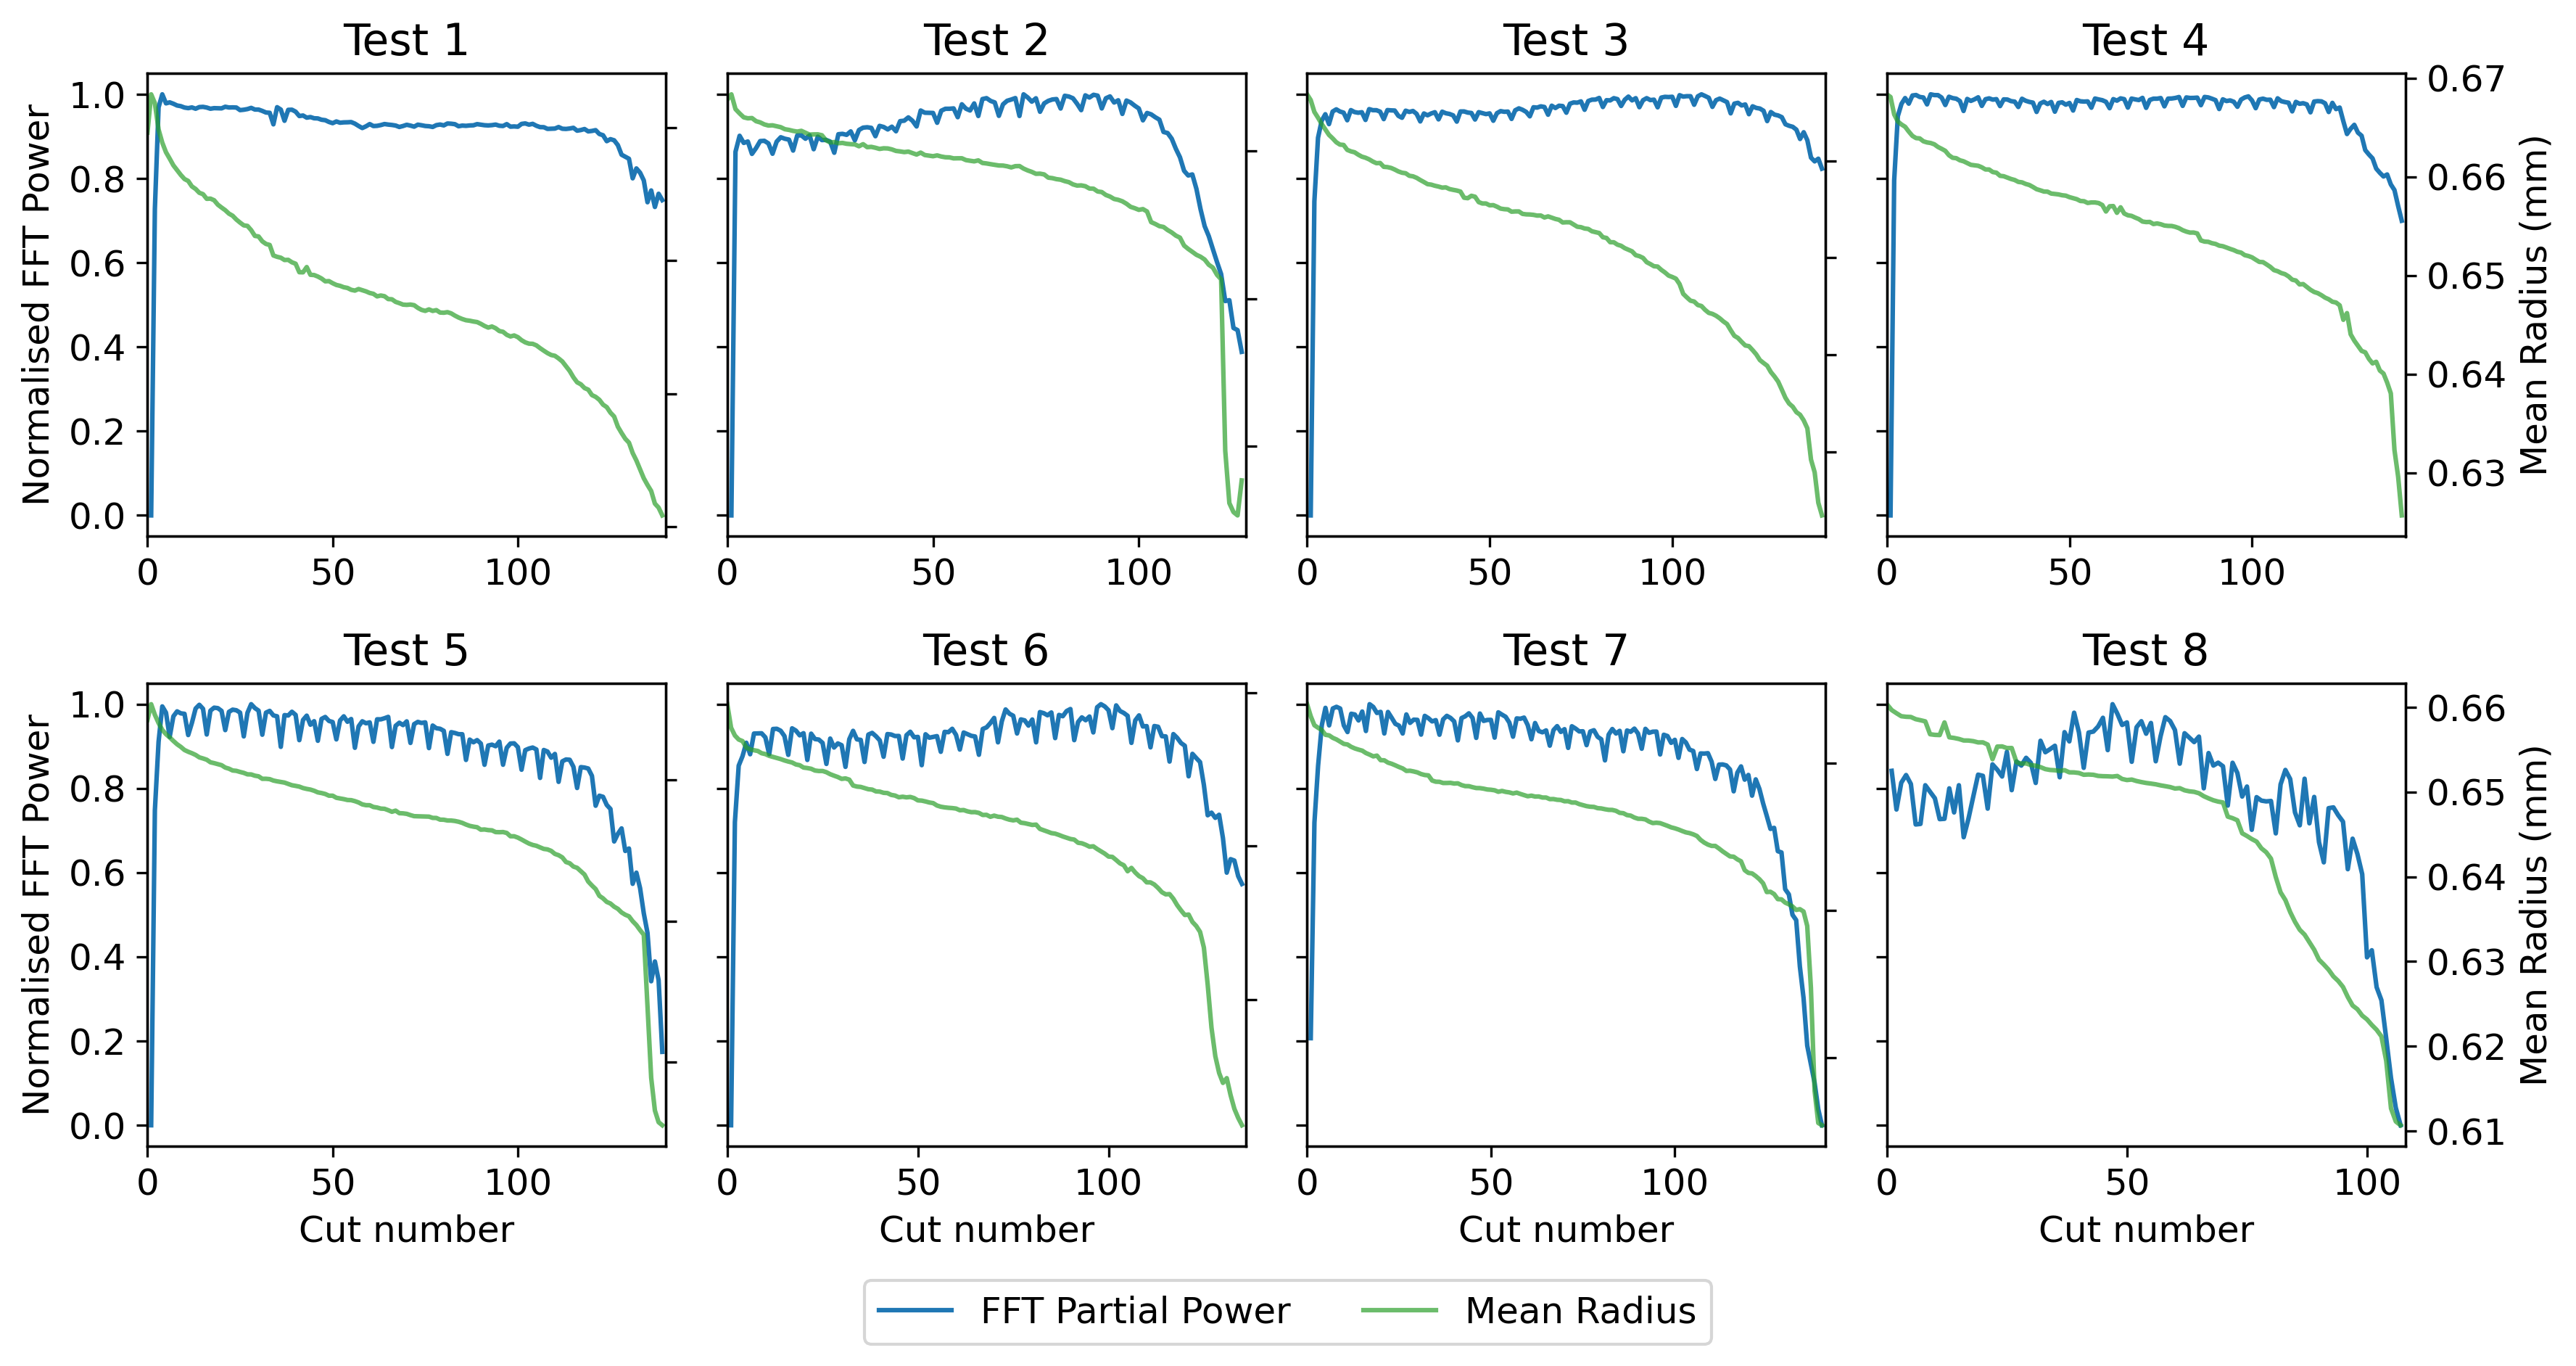

In [18]:
freq = 35

fig, ax = plt.subplots(2, 4, figsize=(12, 6), sharey='row', dpi=300)
ax = ax.ravel()
for i, exp in enumerate(exps):
    f = np.array(exp.ae.fft[1000])
    # avg over 10kHz
    f = f.reshape(-1, 10).mean(axis=1).reshape(f.shape[0],-1)
    f = f.T

    # normalise freq power between 0 and 1
    f = f[freq]
    f = (f - f.min()) / (f.max() - f.min())
    f = np.concatenate(([np.NaN], f))
    # f = _smooth(f, 3)

    ax[i].plot(f, label=f'FFT Partial Power')
    if exp.probe is not None:
        ax2 = ax[i].twinx()
        ax2.plot(exp.features['Mean radius'], 'C2', alpha=0.7, label='Mean Radius')
        # ax2.set_ylim(0, 40)
    ax[i].set_xlim(0, len(exp.features))

    ax[i].set_title(f"Test {i + 1}")
    if i != 3 and i != 7:
        ax2.set_yticklabels([])

    if i == 0 or i == 4:
        ax[i].set_ylabel(f'Normalised FFT Power')
    if i > 3:
        ax[i].set_xlabel('Cut number')
    if i == 3 or i == 7:
        ax2.set_ylabel('Mean Radius (mm)')

l1 = ax[-1].get_lines()[0]
l2 = ax2.get_lines()[0]
lab1 = l1.get_label()
lab2 = l2.get_label()
fig.legend([l1, l2], [lab1, lab2], loc='upper center', bbox_to_anchor=(0.5, 0.02), ncol=2)
fig.tight_layout()

In [19]:
from seaborn import heatmap

In [20]:
exp = exps[0]

f = np.array(exp.ae.fft[1000])
f = f.reshape(-1, 10).mean(axis=1).reshape(f.shape[0],-1)
f = f.T
t = exp.features.drop(columns=['Radius diff', 'Freq 10 kHz'])

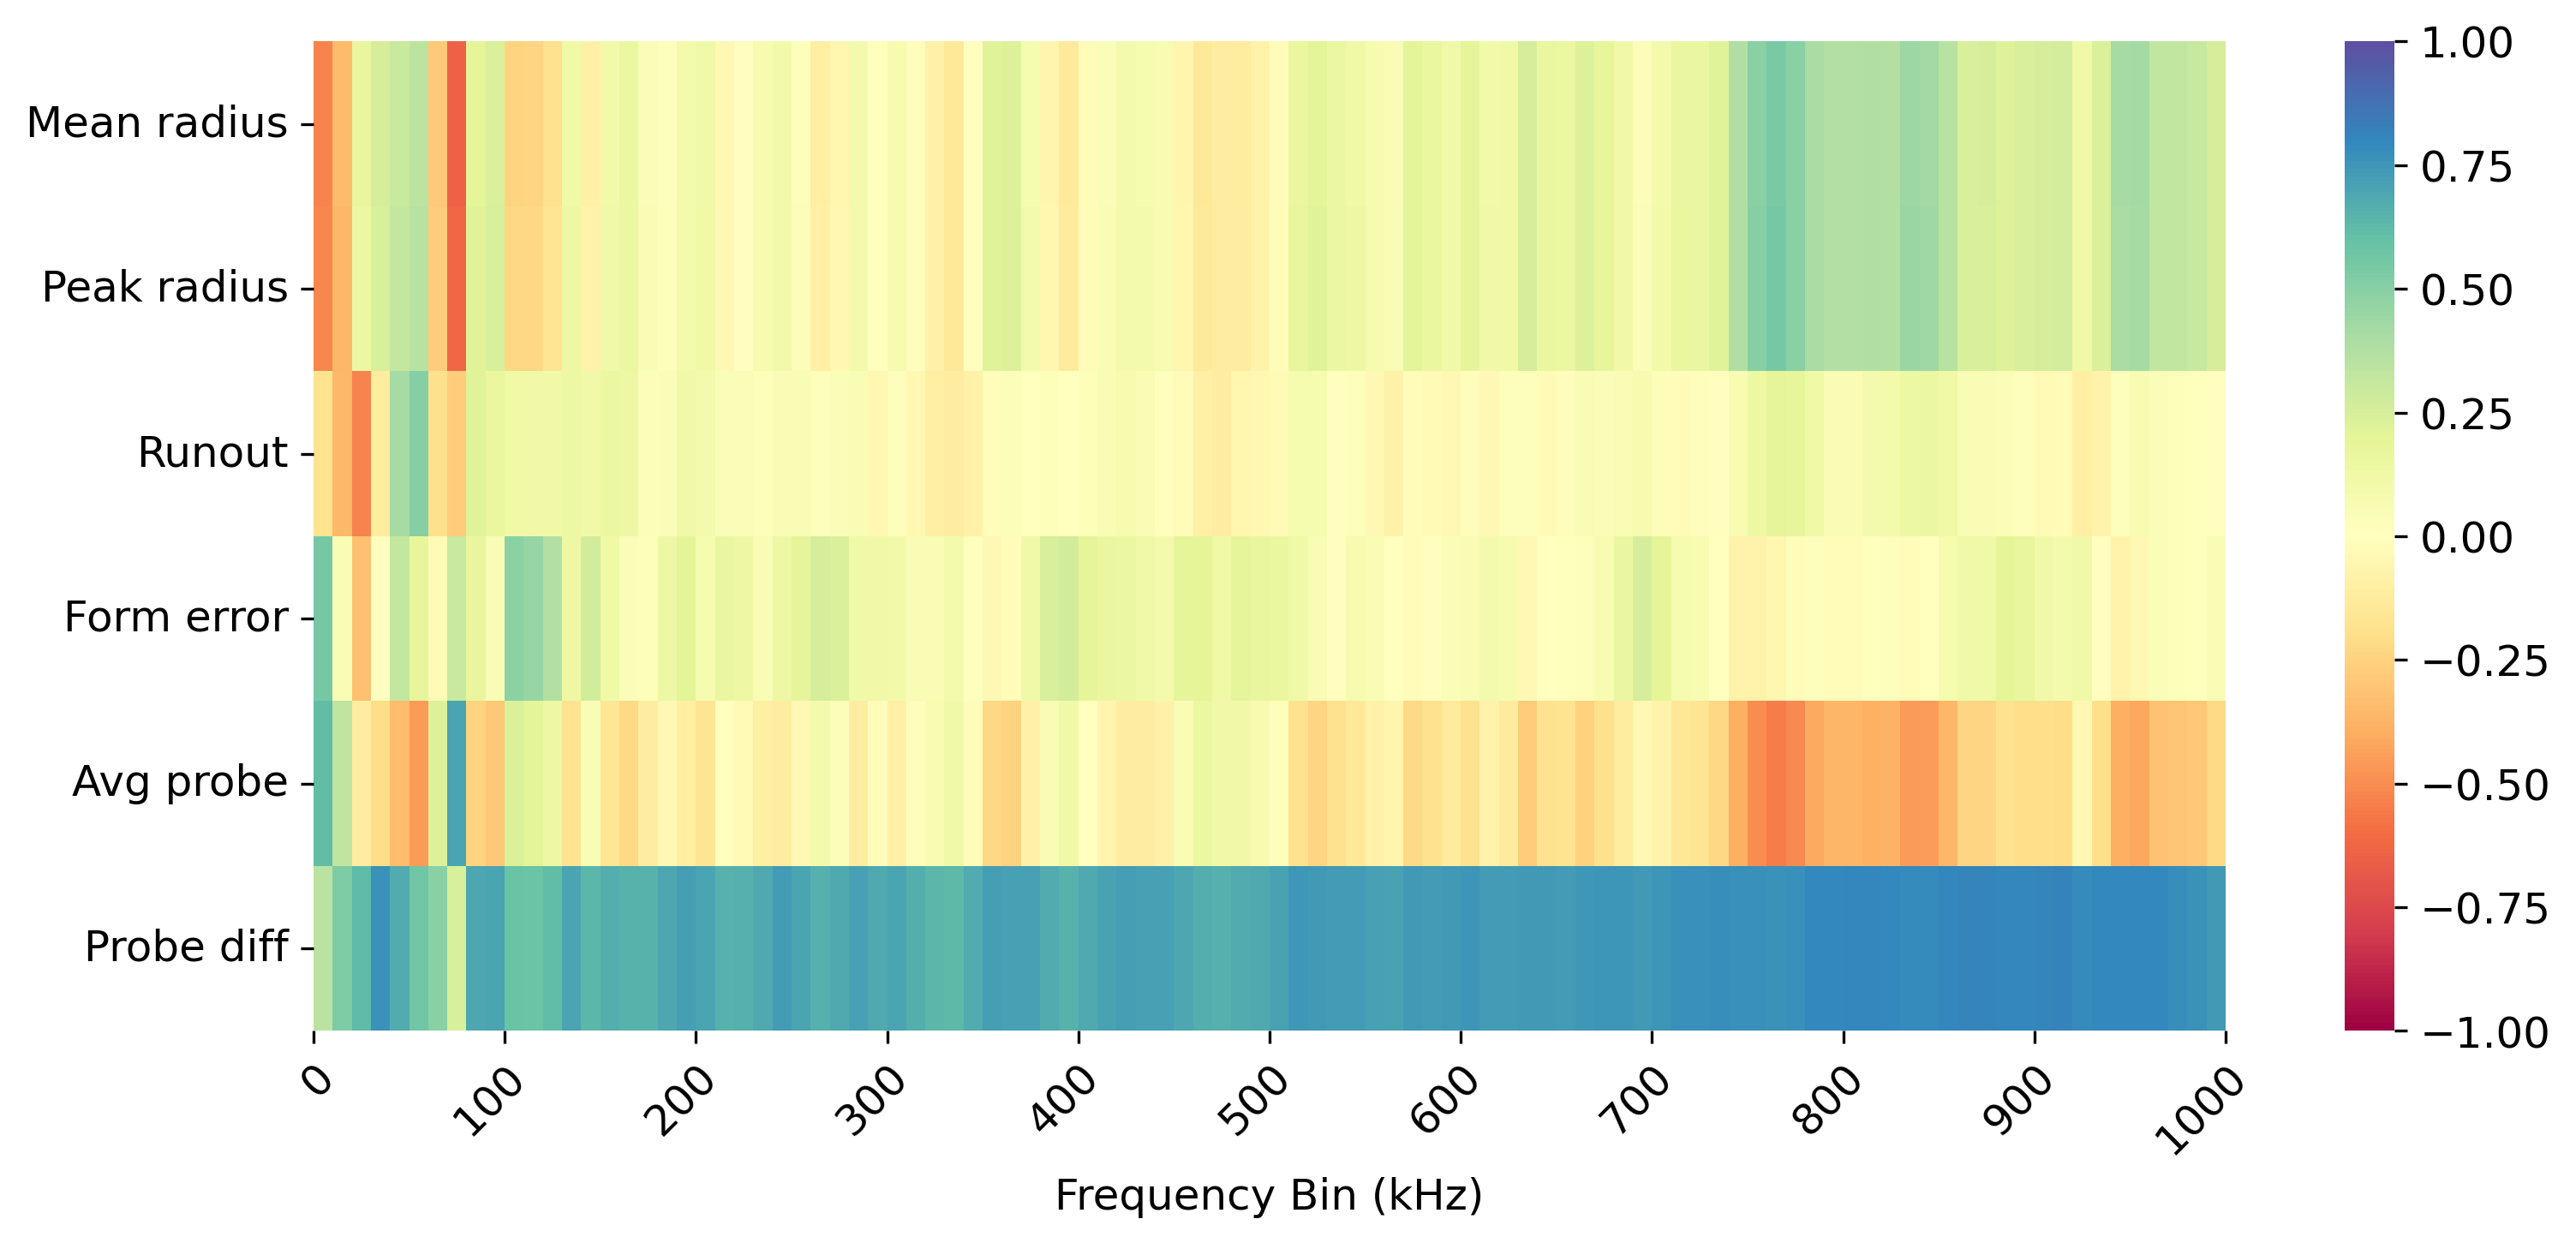

In [21]:
c = np.corrcoef(f, t.iloc[1:, -6:].T)

fig, ax = plt.subplots(1, 1, figsize=(12, 5), dpi=300)
ax = heatmap(c[100:, :100], 
             vmax=1, vmin=-1,
             yticklabels=t.iloc[:, -6:].columns,
             ax=ax,
             cmap='Spectral'
             )
ax.set_xticks(np.arange(0, 110, 10))
ax.set_xticklabels(np.arange(0, 110, 10) * 10)
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
ax.set_xlabel('Frequency Bin (kHz)');

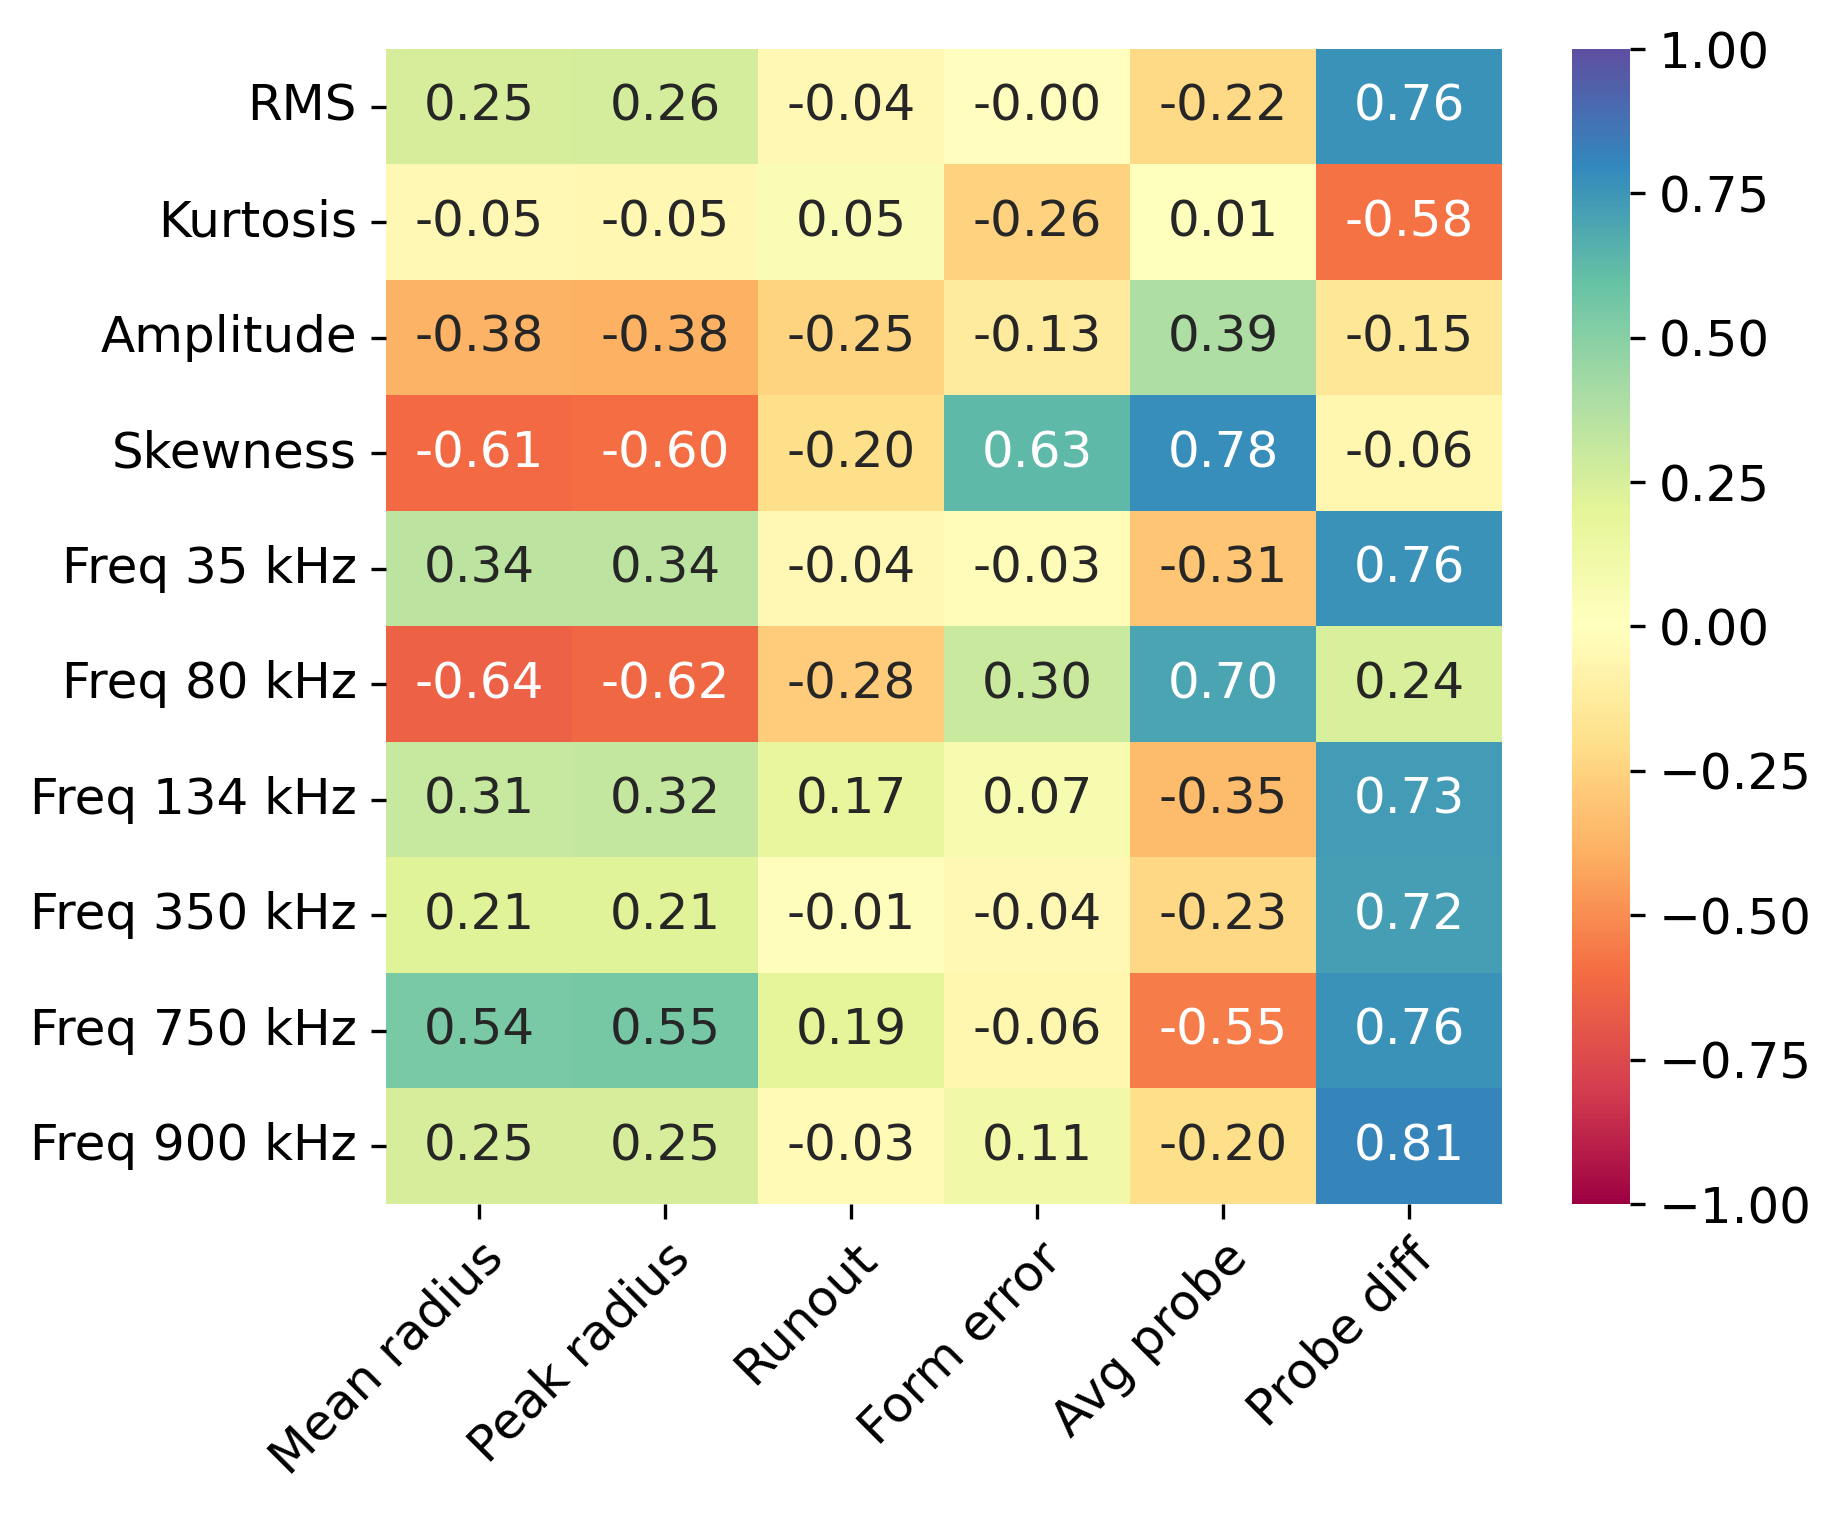

In [22]:
t = exp.features.drop(columns=['Radius diff', 'Freq 10 kHz'])

# normalise freq power between 0 and 1
f_vec = f[35]
f_vec = (f_vec - f_vec.min()) / (f_vec.max() - f_vec.min())
f_vec = np.concatenate(([np.NaN], f_vec))
# f = _smooth(f, 3)
t['Freq 350 kHz'] = f_vec
t.insert(6, 'Freq 350 kHz', t.pop('Freq 350 kHz'))

f_vec = f[90]
f_vec = (f_vec - f_vec.min()) / (f_vec.max() - f_vec.min())
f_vec = np.concatenate(([np.NaN], f_vec))
# f = _smooth(f, 3)
t['Freq 900 kHz'] = f_vec
t.insert(7, 'Freq 900 kHz', t.pop('Freq 900 kHz'))

f_vec = f[7]
f_vec = (f_vec - f_vec.min()) / (f_vec.max() - f_vec.min())
f_vec = np.concatenate(([np.NaN], f_vec))
# f = _smooth(f, 3)
t['Freq 80 kHz'] = f_vec
t.insert(5, 'Freq 80 kHz', t.pop('Freq 80 kHz'))

f_vec = f[76]
f_vec = (f_vec - f_vec.min()) / (f_vec.max() - f_vec.min())
f_vec = np.concatenate(([np.NaN], f_vec))
t['Freq 750 kHz'] = f_vec
t.insert(8, 'Freq 750 kHz', t.pop('Freq 750 kHz'))

c = t.iloc[1:].corr()

fig, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=300)
ax = heatmap(c.iloc[:-6, -6:],
             annot=True, 
             fmt=".2f",
             vmin=-1, vmax=1,
             cmap='Spectral',
             ax=ax,
             )
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor');